# Using Deep Learning for Medical Imaging
In the United States, it takes an average of [1 to 5 days](https://www.ncbi.nlm.nih.gov/pubmed/29132998) to receive a diagnosis after a chest x-ray. This long wait has been shown to increase anxiety in 45% of patients. In addition, impoverished countries usually lack personnel with the technical knowledge to read chest x-rays, assuming an x-ray machine is even available. In such cases, a [short term solution](https://www.theatlantic.com/health/archive/2016/09/radiology-gap/501803/) has been to upload the images online and have volunteers read the images; volunteers diagnose an average of 4000 CT scans per week. This solution works somewhat, but many people travel for days to a clinic and cannot keep traveling back and forth for a diagnosis or treatment, nor can those with more life threatning injuries wait days for a diagnosis. 

Clearly, there is a shortage of trained physicians/radiologists for the amount of care needed.  To help reduce diagnosis time, we can turn to deep learning.  Specifically, I will be using 3 pre-trained models (VGG19, MobileNet, and ResNet50) to apply transfer learning to chest x-rays.  The largest database of chest x-ray images are compiled by the NIH Clinical Center and can be found [here](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community).  The database has  112,120 X-ray images from over 30,000 patients.  There are 14 different pathologies/conditions and a 'no findings' label, for a total of 15 different labels.  Due to time constraints, this notebook will go through the steps as I used transfer learning to train two of these labels: pneumonia and effusion.  

## 1 - Retrieving the Data 
For this project, I used tensorflow and Keras for my deep learning library.  Unfortunately, I ran into reproduciblity problems, which seems to be a common problem (see [machinelearningmastery](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/) and this [StackOverflow question](https://stackoverflow.com/questions/48631576/reproducible-results-using-keras-with-tensorflow-backend)) which is why I set random seeds for python hash seed, numpy, and python in my import section.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import random

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import random

from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from numpy import expand_dims

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score, roc_curve, confusion_matrix, roc_curve,roc_auc_score

import tensorflow as tf

os.environ['PYTHONHASHSEED']='0'
np.random.seed(42)
random.seed(42)

import keras
from keras import backend as K
# import keras.backend.tensorflow_backend as K

tf.random.set_seed(42)
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop, Adam

from keras.applications.vgg19 import preprocess_input, decode_predictions, VGG19
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet import ResNet50

In [2]:
dirpath = 'all_images/'
alldata_df = pd.read_csv('./Data_Entry_2017.csv')

##  2 - Data Exploration
The master dataframe below shows all the info we know regarding each image, including the image filename, label(s), patient information, and image height and width.  

In [3]:
alldata_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


### 2.1 - Pathologies
One thing to notice is that each image can have multiple labels.  To isolate each individual pathology, I will create a column for each pathology and use 0 and 1 to indicate if the image has that pathology or not respectively.  

In [4]:
alldata_df['Labels List'] = alldata_df['Finding Labels'].apply(lambda x: x.split('|'))

In [5]:
pathology_lst = ['Cardiomegaly', 'No Finding', 'Hernia', 'Infiltration', 'Nodule',
       'Emphysema', 'Effusion', 'Atelectasis', 'Pleural_Thickening',
       'Pneumothorax', 'Mass', 'Fibrosis', 'Consolidation', 'Edema',
       'Pneumonia']

In [6]:
def get_label(col, pathology):
    if pathology in col:
        return 1
    else:
        return 0

In [7]:
for pathology in pathology_lst:
    alldata_df[pathology] = alldata_df['Labels List'].apply(lambda x: get_label(x, pathology))

Below is a table of the percentage of each type of label that makes up the dataset.  Not surprisingly, the 'no findings' label makes up the majority of the images, at about 50%.  The two pathologies I'd like to train are pneumonia and effusion.  Pneumonia, a pathology that most of us has heard of, takes up about 1.2% of the dataset whereas effusion is ~10%.  This corresponds to a total of 1431 and 13317 images for pneumonia and effusion respectively.  Due to the small amount of images available for pneumonia, I suspect it will be difficult to get good results.  

In [8]:
alldata_df[pathology_lst].sum()/alldata_df.shape[0]*100

Cardiomegaly           2.475919
No Finding            53.836068
Hernia                 0.202462
Infiltration          17.743489
Nodule                 5.646629
Emphysema              2.244024
Effusion              11.877453
Atelectasis           10.309490
Pleural_Thickening     3.019087
Pneumothorax           4.728862
Mass                   5.156975
Fibrosis               1.503746
Consolidation          4.162504
Edema                  2.054049
Pneumonia              1.276311
dtype: float64

### 2.2 - Image Data
There are two things to explore with the image data before diving into creating models.  Its useful to know the height and widths of the images, especially since the models I'm using are expecting a dimension of 224 x 224 pixels.  

The distribution of the heights and widths are shown in the histograms below.  Most of the images have a height of 2000 pixels, although a good number of them hover at 2500 and 3000, with a minimum of ~970 pixels. The width of the images also has 3 distinct peaks, but the max is at 2500, and significant peaks at 2000 and 3000 pixels, with a minimum of ~1140 pixels.  All the images have dimensions greater than 224.  

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


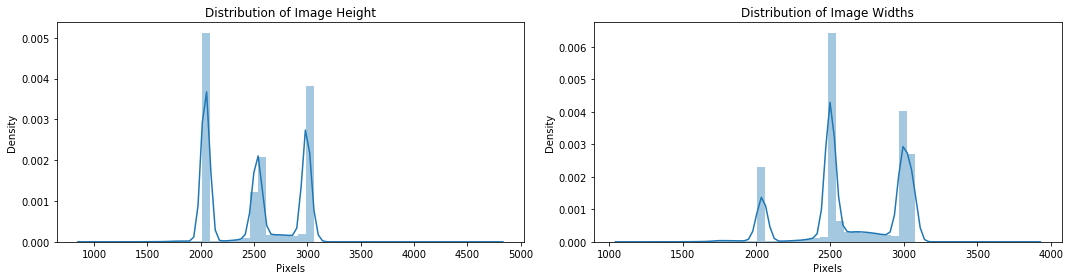

In [9]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.distplot(alldata_df['Height]'], ax = axis1)
sns.distplot(alldata_df['OriginalImage[Width'], ax = axis2)

axis1.set_title('Distribution of Image Height')
axis2.set_title('Distribution of Image Widths')

for ax in [axis1, axis2]:
    ax.set_xlabel('Pixels')
    ax.set_ylabel('Density')

plt.tight_layout()

Another column is the view position.  There are two unique values for this columns: PA and AP.  These represent if the X-rays pass from the back to the front or vice versa.  Thus, I'd like to find out if there are any stark differences in the images between the two view positions.  Most of the images are in the PA viewing position.  This is preferred because AP position creates 'shadows', but 'AP' images are taken because the patient is unable to stand up for the 'PA' position and need to lie down on a table.

In [10]:
alldata_df['View Position'].value_counts()/alldata_df.shape[0]*100

PA    60.033892
AP    39.966108
Name: View Position, dtype: float64

In [11]:
def get_images(filename_df, target_pathology, num_images = 500, imageSize = 224):
    X = []
    
    sample_df = filename_df.sample(n = num_images)
    sample_df.reset_index(drop = True, inplace = True)
    truncated_image_filename_lst = sample_df['Image Index'].values
    full_image_filename_lst = []
    
    for truncated_filename in truncated_image_filename_lst:
        full_image_filename_lst.append(find_file(truncated_filename))
        
    for i, file in enumerate(full_image_filename_lst):
        img_file = cv2.imread(file)
        img_file = cv2.resize(img_file, (imageSize, imageSize), interpolation = cv2.INTER_CUBIC)
        img_arr = np.asarray(img_file)
        if img_arr.shape == (224, 224, 3): 
            X.append(img_arr)
        else:
            sample_df.drop(i, inplace = True)
    y = sample_df[target_pathology]

    return np.array(X), np.array(y)

In [12]:
# images extractred from 12 files, 
image_dir = sorted([dir for dir in os.listdir(dirpath) if 'images' in dir ])

def find_file(filename):
    for dirfile in image_dir:
        if filename in os.listdir(dirpath + dirfile + '/images'):
            return dirpath  + dirfile + '/images/' + filename


In [13]:
pa_images, _ = get_images(alldata_df[alldata_df['View Position']=='PA'], 'No Finding', num_images = 9, imageSize = 224)

In [14]:
ap_images, _ = get_images(alldata_df[(alldata_df['View Position']=='AP') & (alldata_df['No Finding']==1)], 'No Finding', num_images = 9, imageSize = 224)

Below I've plotted 16 images total.  To make sure there aren't any differences due to pathologies, I only took from the 'no findings' label.  The first 8 images are X-rays in the PA position (the majority), and the latter 8 images are in the AP position.  

The PA images seem to generally have a white mass near the bottom, although how much white varies from image to image.  In addition, there is a small protrusion to the left of the spine, and a larger protrusion to the right of the spine.  

The AP images are similar, but much blurrier, possibly due to the shadows mentioned before.  

Images for PA view


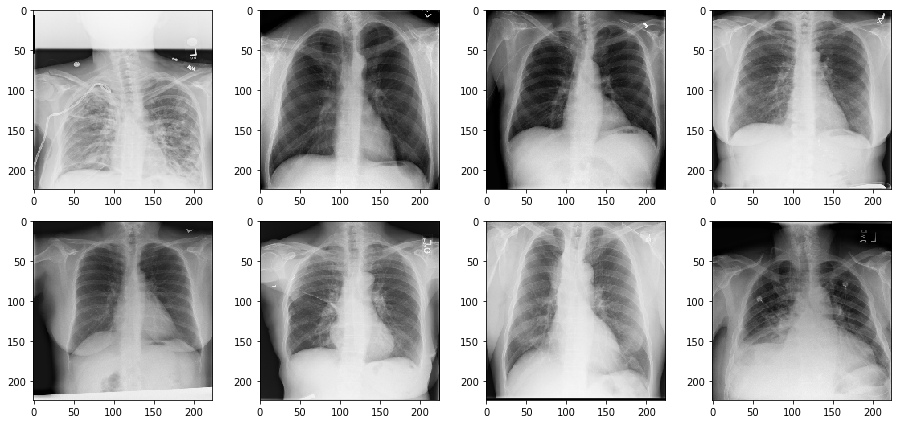

In [15]:
plt.figure(figsize = (13, 6))
print('Images for PA view')
for i in range(8):
    plt.subplot(2, 4, i+1)
    tmp1 = pa_images[i].astype(np.uint8)
    plt.imshow(tmp1)
    plt.tight_layout()

Images for AP view


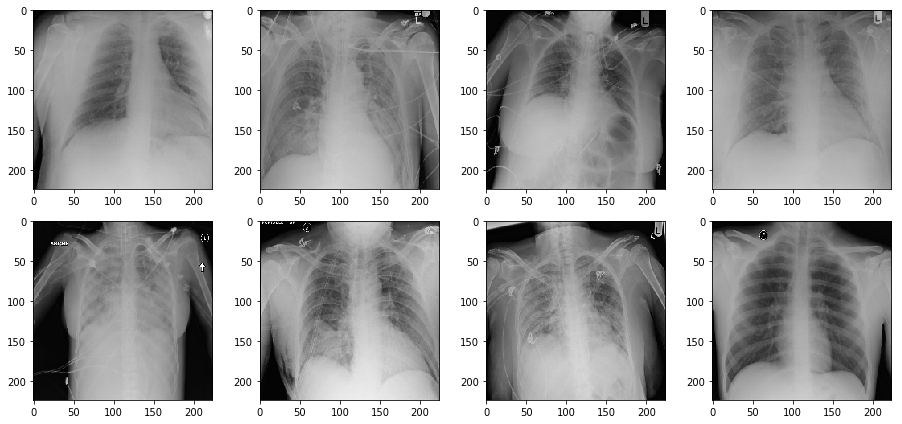

In [16]:
plt.figure(figsize = (13, 6))
print('Images for AP view')
for i in range(8):
    plt.subplot(2, 4, i+1)
    tmp1 = ap_images[i].astype(np.uint8)
    plt.imshow(tmp1)
    plt.tight_layout()

I looked at the percentages of AP vs PA view positions for 'pneumonia' and 'effusion', and threw in the overall percentage and 'no finding' for comparison.  The overall and no findings are pretty close, with 'PA' positions at 60-65%.  However, the 'PA' positions for 'pneumonia' and 'effusion' are lower, at 45-50%.  Although removing 'AP' images might improve the models, for pneumonia it would leave too little images to train on.

In [17]:
pathology_percent_lst = ['No Finding', 'Pneumonia', 'Effusion']
pa_percent_lst = [alldata_df[(alldata_df[path]==1) & (alldata_df['View Position'] == 'PA')].shape[0]/alldata_df[(alldata_df[path]==1)].shape[0]*100 for path in pathology_percent_lst]
ap_percent_lst = [alldata_df[(alldata_df[path]==1) & (alldata_df['View Position'] == 'AP')].shape[0]/alldata_df[(alldata_df[path]==1)].shape[0]*100 for path in pathology_percent_lst]

pathology_percent_lst.insert(0, 'Overall')
pa_percent_lst.insert(0, alldata_df[alldata_df['View Position']=='PA'].shape[0]/alldata_df.shape[0]*100)
ap_percent_lst.insert(0, alldata_df[alldata_df['View Position']=='AP'].shape[0]/alldata_df.shape[0]*100)

In [18]:
ap_pa_percent_df = pd.DataFrame(np.array([pa_percent_lst, ap_percent_lst]), 
                                columns = pathology_percent_lst,
                               index = ['PA', 'AP'])

ap_pa_percent_df

,Overall,No Finding,Pneumonia,Effusion
PA,60.033892,65.111579,44.025157,49.478111
AP,39.966108,34.888421,55.974843,50.521889


### 2.3 - Splitting into Training, Validation, and Test Sets
Lastly, the original [paper](http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf) split the images into training/validation and test sets and released that information to the public so we can easily compare our results to theirs.  I have split my own data into the same training/validation, and test sets as the original authors.

In [19]:
train_val_filenames = pd.read_csv('./train_val_list.txt', sep=" ", header=None)
test_filenames = pd.read_csv('./test_list.txt', sep=" ", header=None)

In [20]:
train_val_filenames.shape[0] + test_filenames.shape[0]

112120

In [21]:
train_val_df = alldata_df[alldata_df['Image Index'].isin(train_val_filenames.values.flatten())]
test_df = alldata_df[alldata_df['Image Index'].isin(test_filenames.values.flatten())]

## 3 - Pneumonia
First, I will be performing transfer learning on pneumonia images.  In order, the three models I will be using are VGG18, MobileNet, and ResNet50.  

### 3.1 - VGG19 Model
First I must preprocess the images.  The VGG model is expecting an image size of 224 x 224 pixels

In [22]:
imgSize = 224

Note:  After writing this notebook, I realized my smaller test set should have the same distribution of pathologies as the original test set.  This will be corrected the next time I improve upon this project.  

In [23]:
# Get test images
Xtest_pneu, ytest_pneu = get_images(test_df[test_df['Pneumonia']==1], 
                                    'Pneumonia', 
                                    num_images = test_df[test_df['Pneumonia']==1].shape[0], 
                                    imageSize = imgSize)
Xtest_notpneu, ytest_notpneu = get_images(test_df[test_df['Pneumonia']==0], 
                                          'Pneumonia', 
                                          num_images = test_df[test_df['Pneumonia']==1].shape[0], 
                                          imageSize = imgSize)

X_test_pneu = np.concatenate((Xtest_pneu, Xtest_notpneu), axis = 0)
y_test_pneu = np.concatenate((ytest_pneu, ytest_notpneu))

I use sklearn's train_test_split function to shuffle test set.  Unfortunately that means I lose 1% of the images, so it leaves me with 1099 images total in the test set.  

In [24]:
_, X_test_pneu, _, y_test_pneu = train_test_split(X_test_pneu, 
                                                  y_test_pneu, 
                                                  test_size=0.99, 
                                                  random_state=42, 
                                                  stratify = y_test_pneu)

The training and validation sets have a total of 1752 and 351 images respectively.

In [25]:
# get training images and split into validation set
Xtrain_pneu, ytrain_pneu = get_images(train_val_df[train_val_df['Pneumonia']==1], 
                                      'Pneumonia', 
                                      num_images = train_val_df[train_val_df['Pneumonia']==1].shape[0], 
                                      imageSize = imgSize)
Xtrain_notpneu, ytrain_notpneu = get_images(train_val_df[train_val_df['Pneumonia']==0], 
                                            'Pneumonia', 
                                            num_images = train_val_df[train_val_df['Pneumonia']==1].shape[0], 
                                            imageSize = imgSize)

Xtrain_pneu = np.concatenate((Xtrain_pneu, Xtrain_notpneu), axis = 0)
ytrain_pneu = np.concatenate((ytrain_pneu, ytrain_notpneu))

X_train_pneu, X_val_pneu, y_train_pneu, y_val_pneu = train_test_split(Xtrain_pneu, 
                                                                      ytrain_pneu, 
                                                                      test_size=0.2, 
                                                                      random_state=42, 
                                                                      stratify = ytrain_pneu)

Next, I need to convert the images into a format accepted by the VGG model.

In [26]:
def convert_X_data(Xtrain, Xval, Xtest, imageSize = 224, num_classes = 2):
    if K.image_data_format() == 'channels_first':
        Xtrain_model = Xtrain.reshape(Xtrain.shape[0], 3, imageSize, imageSize)
        Xval_model = Xval.reshape(Xval.shape[0], 3, imageSize, imageSize)
        Xtest_model = Xtest.reshape(Xtest.shape[0], 3, imageSize, imageSize)
    else:
        Xtrain_model = Xtrain.reshape(Xtrain.shape[0], imageSize, imageSize, 3)
        Xval_model = Xval.reshape(Xval.shape[0], imageSize, imageSize, 3)
        Xtest_model = Xtest.reshape(Xtest.shape[0], imageSize, imageSize, 3)
    #     input_shape = (img_rows, img_cols, 1)

    Xtrain_model = Xtrain_model.astype('float32')
    Xval_model = Xval_model.astype('float32')
    Xtest_model = Xtest_model.astype('float32')
    
    Xtrain_model = preprocess_input(Xtrain_model)
    Xval_model = preprocess_input(Xval_model)
    Xtest_model = preprocess_input(Xtest_model)
    
    return Xtrain_model, Xval_model, Xtest_model

In [27]:
def convert_y_data(ytrain, yval, ytest, num_classes = 2):
    ytrain_model = keras.utils.to_categorical(ytrain, num_classes)
    yval_model = keras.utils.to_categorical(yval, num_classes)
    ytest_model = keras.utils.to_categorical(ytest, num_classes)
    
    return ytrain_model, yval_model, ytest_model

In [28]:
X_train_pneu_model, X_val_pneu_model, X_test_pneu_model = convert_X_data(X_train_pneu, 
                                                                   X_val_pneu, 
                                                                   X_test_pneu, 
                                                                   imageSize = imgSize, 
                                                                   num_classes = 2)
y_train_pneu_model, y_val_pneu_model, y_test_pneu_model = convert_y_data(y_train_pneu, 
                                                                   y_val_pneu, 
                                                                   y_test_pneu, 
                                                                   num_classes = 2)

Lastly, keras only has built in functions for accuracy and loss.  I am interested in looking at accuracy, precision, recall, and f1 scores however, so I will write my own function to get these metrics.  

The two metrics I'm most concerned about are the recall and f1-score.  I am interested in the recall because for a medical related dataset, I believe it is best to reduce false negatives.  However, I know there are cases where the model can predict all 0 or all 1, which would skew the precision and recalls.  As such, it is important to look at f1-scores as well. 

In [29]:
def get_metrics(model, xtest, ytrue, verbose = True):
    y_pred_probs = model.predict(xtest)
    try:
        y_pred_classes = model.predict_classes(xtest)
    except AttributeError:
        y_pred_classes = [np.argmax(i) for i in y_pred_probs]
    
    y_pred_probs = y_pred_probs[:, 0]
    try:
        y_pred_classes = y_pred_classes[:, 0]
    except: #IndexError:
        pass
    
    if verbose:
        print('Accuracy Score: {}'.format(accuracy_score(ytrue, y_pred_classes)))
        print('Precision Score: {}'.format(precision_score(ytrue, y_pred_classes)))
        print('Recall: {}'.format(recall_score(ytrue, y_pred_classes)))
        print('F1 Score: {}'.format(f1_score(ytrue, y_pred_classes)))
        print('Confusion matrix: \n{}'.format(confusion_matrix(ytrue, y_pred_classes)))
    
    return accuracy_score(ytrue, y_pred_classes), precision_score(ytrue, y_pred_classes), recall_score(ytrue, y_pred_classes), f1_score(ytrue, y_pred_classes)

#### 3.1.1 - VGG Baseline with Pneumonia Images
The first step is to establish what the baseline metrics will be for the VGG model.  To do this, first I import the layers from the VGG model.  Since this model was trained on the ImageNet dataset, it expects to predict from 1000 classes. I replace this last layer with a dense layer with 2 classes and softmax activation, and compile the model with keras's categorical cross entropy loss function.  Lastly, due to the reproducibility issues mentioned in the beginning, I run the model 3 times and average the metrics and show the standard deviation.

For the baseline metric, the model has an accuracy of ~50% while the precision is ~0.55 and recall and f1 score at ~0.23, so this is just about as good as flipping a coin given that the test set is balanced.  In addition, the standard deviation for the recall and precision scores are just about as big as the averaged scores themselves, so the reliability of this baseline model is very poor.  

In [30]:
num_classes = 2

In [31]:
vgg_model = VGG19()

In [32]:
vgg_baseline_acc_scores = []
vgg_baseline_prec_scores = []
vgg_baseline_recall_scores = []
vgg_baseline_f1_scores = []

for i in range(3):
    vgg_model_baseline = Sequential()
    for layer in vgg_model.layers[:-1]:
        vgg_model_baseline.add(layer)
        
    vgg_model_baseline.add(Dense(num_classes, activation = 'softmax'))

    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in vgg_model_baseline.layers:
        layer.trainable = False

    vgg_model_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])


    batchsize = 64

    vgg_model_baseline_history = vgg_model_baseline.fit(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                        validation_data=(X_val_pneu_model, y_val_pneu_model))

    acc, prec, recall, f1 = get_metrics(vgg_model_baseline, X_test_pneu_model, y_test_pneu, verbose = True)
    vgg_baseline_acc_scores.append(acc)
    vgg_baseline_prec_scores.append(prec)
    vgg_baseline_recall_scores.append(recall)
    vgg_baseline_f1_scores.append(f1)

Accuracy Score: 0.5050045495905369
Precision Score: 0.5384615384615384
Recall: 0.06375227686703097
F1 Score: 0.11400651465798047
Confusion matrix: 
[[520  30]
 [514  35]]
Accuracy Score: 0.4767970882620564
Precision Score: 0.4818435754189944
Recall: 0.6284153005464481
F1 Score: 0.5454545454545455
Confusion matrix: 
[[179 371]
 [204 345]]
Accuracy Score: 0.5031847133757962
Precision Score: 0.6153846153846154
Recall: 0.014571948998178506
F1 Score: 0.028469750889679714
Confusion matrix: 
[[545   5]
 [541   8]]


In [33]:
print('Accuracy of VGG baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(vgg_baseline_acc_scores) * 100, np.std(vgg_baseline_acc_scores)*100))
print('Precision of VGG baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_baseline_prec_scores), np.std(vgg_baseline_prec_scores)))
print('Recall of VGG baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_baseline_recall_scores), np.std(vgg_baseline_recall_scores)))
print('f1 score of VGG baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_baseline_f1_scores), np.std(vgg_baseline_f1_scores)))

Accuracy of VGG baseline model: 49.50 +/- 1.29%
Precision of VGG baseline model: 0.545 +/- 0.055
Recall of VGG baseline model: 0.236 +/- 0.279
f1 score of VGG baseline model: 0.229 +/- 0.226


#### 3.1.2 - Training Layers with VGG19 and Pneumonia Images
A way to fine tune and hopefully improve upon this baseline model is to unfreeze certain layers.  That is, the weights imported by the VGG (or any) model is optimized for the ImageNet dataset.  Unfreezing layers allows the model to learn the features of your current dataset.  Typically, the first layers of the models are kept frozen as they are able to extract big/common features, while the last layers are able to extract features that are more specific to your dataset.  

VGG19 has 26 layers, and I found that it is optimal to train the last 4 layers, leaving the first 22 layers frozen.  With this model, the accuracy rises slightly to ~53% while the precision stays the same.  Recall and f1-score rises to over 0.60.  In addition, standard deviations have drastically reduced.

In [34]:
vgg_frozen_acc_scores = []
vgg_frozen_prec_scores = []
vgg_frozen_recall_scores = []
vgg_frozen_f1_scores = []

for i in range(3):
    vgg_model_frozen = Sequential()
    for layer in vgg_model.layers[:-1]:
        vgg_model_frozen.add(layer)
        
    vgg_model_frozen.add(Dense(num_classes, activation = 'softmax'))

    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in vgg_model_frozen.layers[:-4]:
        layer.trainable = False

    vgg_model_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])


    batchsize = 64

    vgg_model_frozen_history = vgg_model_frozen.fit(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                        validation_data=(X_val_pneu_model, y_val_pneu_model))

    acc, prec, recall, f1 = get_metrics(vgg_model_frozen, X_test_pneu_model, y_test_pneu, verbose = True)
    vgg_frozen_acc_scores.append(acc)
    vgg_frozen_prec_scores.append(prec)
    vgg_frozen_recall_scores.append(recall)
    vgg_frozen_f1_scores.append(f1)

Accuracy Score: 0.54049135577798
Precision Score: 0.525
Recall: 0.8415300546448088
F1 Score: 0.6466060181945418
Confusion matrix: 
[[132 418]
 [ 87 462]]
Accuracy Score: 0.5313921747042766
Precision Score: 0.5177824267782427
Recall: 0.9016393442622951
F1 Score: 0.6578073089700996
Confusion matrix: 
[[ 89 461]
 [ 54 495]]
Accuracy Score: 0.54049135577798
Precision Score: 0.5325443786982249
Recall: 0.6557377049180327
F1 Score: 0.5877551020408164
Confusion matrix: 
[[234 316]
 [189 360]]


In [35]:
print('Accuracy of VGG model with last 4 layers trained: {:0.2f} +/- {:0.2f}%'.format(np.mean(vgg_frozen_acc_scores) * 100, np.std(vgg_frozen_acc_scores)*100))
print('Precision of VGG model with last 4 layers trained: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_frozen_prec_scores), np.std(vgg_frozen_prec_scores)))
print('Recall of VGG model with last 4 layers trained: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_frozen_recall_scores), np.std(vgg_frozen_recall_scores)))
print('f1 score of VGG model with last 4 layers trained: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_frozen_f1_scores), np.std(vgg_frozen_f1_scores)))

Accuracy of VGG model with last 4 layers trained: 53.75 +/- 0.43%
Precision of VGG model with last 4 layers trained: 0.525 +/- 0.006
Recall of VGG model with last 4 layers trained: 0.800 +/- 0.105
f1 score of VGG model with last 4 layers trained: 0.631 +/- 0.031


#### 3.1.3 - Adding Augmented Images to VGG19 Model with Pneumonia Images
So far, I've been able to get an ok f1 score, but an accuracy of 55% concerns me because that's barely doing beter than randomly guessing if an image shows pneumonia or not.  I believe part of that is the low number of images in the training set, with a total of 1752 images.  Normally, a deep learning model will want hundreds of thousands of images.  To help with this, I can generate images from the ones I already have by altering them.  The alterations are defined in the Image Data Generator function below, but to summarize, the image generator can zoom, shift the image horizontally, or shift the image vertically.  If the image is shifted, black pixels fill in the empty space.

As usual, I want to get a baseline for this augmented images model.  Unfortunately, the metrics seem to be similar to the non-augmented baseline scores.  

In [36]:
gen = ImageDataGenerator(zoom_range=0.05, 
                         height_shift_range=0.05, 
                         width_shift_range=0.05, 
                         fill_mode = 'constant', 
                         cval = 0)

In [37]:
vgg_aug_baseline_acc_scores = []
vgg_aug_baseline_prec_scores = []
vgg_aug_baseline_recall_scores = []
vgg_aug_baseline_f1_scores = []

for i in range(3):
    vgg_model_aug_baseline = Sequential()
    for layer in vgg_model.layers[:-1]:
        vgg_model_aug_baseline.add(layer)
        
    vgg_model_aug_baseline.add(Dense(num_classes, activation = 'softmax'))

    for layer in vgg_model_aug_baseline.layers:
        layer.trainable = False

    vgg_model_aug_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])


    batchsize = 64

    vgg_model_aug_baseline_history = vgg_model_aug_baseline.fit_generator(gen.flow(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize), 
                        steps_per_epoch = len(X_train_pneu_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_pneu_model, 
                                        y_val_pneu_model))

    acc, prec, recall, f1 = get_metrics(vgg_model_aug_baseline, X_test_pneu_model, y_test_pneu, verbose = True)
    vgg_aug_baseline_acc_scores.append(acc)
    vgg_aug_baseline_prec_scores.append(prec)
    vgg_aug_baseline_recall_scores.append(recall)
    vgg_aug_baseline_f1_scores.append(f1)

Accuracy Score: 0.5022747952684259
Precision Score: 0.5625
Recall: 0.01639344262295082
F1 Score: 0.03185840707964602
Confusion matrix: 
[[543   7]
 [540   9]]
Accuracy Score: 0.5086442220200182
Precision Score: 0.5652173913043478
Recall: 0.07103825136612021
F1 Score: 0.1262135922330097
Confusion matrix: 
[[520  30]
 [510  39]]
Accuracy Score: 0.521383075523203
Precision Score: 0.5166908563134979
Recall: 0.6484517304189436
F1 Score: 0.5751211631663975
Confusion matrix: 
[[217 333]
 [193 356]]


In [38]:
print('Accuracy of VGG augmented baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(vgg_aug_baseline_acc_scores) * 100, np.std(vgg_aug_baseline_acc_scores)*100))
print('Precision of VGG augmented baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_aug_baseline_prec_scores), np.std(vgg_aug_baseline_prec_scores)))
print('Recall of VGG augmented baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_aug_baseline_recall_scores), np.std(vgg_aug_baseline_recall_scores)))
print('f1 score of VGG augmented baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_aug_baseline_f1_scores), np.std(vgg_aug_baseline_f1_scores)))

Accuracy of VGG augmented baseline model: 51.08 +/- 0.79%
Precision of VGG augmented baseline model: 0.548 +/- 0.022
Recall of VGG augmented baseline model: 0.245 +/- 0.286
f1 score of VGG augmented baseline model: 0.244 +/- 0.237


Again, I'd like to fine tune the augmented image model by letting some layers be trainable.  I found the optimal number of trainable layers to be 5.  The accuracy of the augmented model with trainable layers is slightly higher, but the standard deviation is also larger, and the precision, recall, and f1-score are either the same or lower than the baseline model with trainable layers.

In [39]:
vgg_aug_frozen_acc_scores = []
vgg_aug_frozen_prec_scores = []
vgg_aug_frozen_recall_scores = []
vgg_aug_frozen_f1_scores = []

for i in range(3):
    vgg_model_aug_frozen = Sequential()
    for layer in vgg_model.layers[:-1]:
        vgg_model_aug_frozen.add(layer)
        
    vgg_model_aug_frozen.add(Dense(num_classes, activation = 'softmax'))

    for layer in vgg_model_aug_frozen.layers[:-5]:
        layer.trainable = False

    vgg_model_aug_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])


    batchsize = 64

    vgg_model_aug_frozen_history = vgg_model_aug_frozen.fit_generator(gen.flow(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize), 
                        steps_per_epoch = len(X_train_pneu_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_pneu_model, 
                                        y_val_pneu_model))

    acc, prec, recall, f1 = get_metrics(vgg_model_aug_frozen, X_test_pneu_model, y_test_pneu, verbose = True)
    vgg_aug_frozen_acc_scores.append(acc)
    vgg_aug_frozen_prec_scores.append(prec)
    vgg_aug_frozen_recall_scores.append(recall)
    vgg_aug_frozen_f1_scores.append(f1)

Accuracy Score: 0.5259326660600546
Precision Score: 0.5360824742268041
Recall: 0.3788706739526412
F1 Score: 0.4439701173959445
Confusion matrix: 
[[370 180]
 [341 208]]
Accuracy Score: 0.54049135577798
Precision Score: 0.5338461538461539
Recall: 0.6320582877959927
F1 Score: 0.5788156797331109
Confusion matrix: 
[[247 303]
 [202 347]]
Accuracy Score: 0.5577797998180164
Precision Score: 0.544055944055944
Recall: 0.7085610200364298
F1 Score: 0.615506329113924
Confusion matrix: 
[[224 326]
 [160 389]]


In [40]:
print('Accuracy of VGG augmented model with last 5 layers trained: {:0.2f} +/- {:0.2f}%'.format(np.mean(vgg_aug_frozen_acc_scores) * 100, np.std(vgg_aug_frozen_acc_scores)*100))
print('Precision of VGG augmented model with last 5 layers trained: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_aug_frozen_prec_scores), np.std(vgg_aug_frozen_prec_scores)))
print('Recall of VGG augmented model with last 5 layers trained: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_aug_frozen_recall_scores), np.std(vgg_aug_frozen_recall_scores)))
print('f1 score of VGG augmented model with last 5 layers trained: {:0.3f} +/- {:0.3f}'.format(np.mean(vgg_aug_frozen_f1_scores), np.std(vgg_aug_frozen_f1_scores)))

Accuracy of VGG augmented model with last 5 layers trained: 54.14 +/- 1.30%
Precision of VGG augmented model with last 5 layers trained: 0.538 +/- 0.004
Recall of VGG augmented model with last 5 layers trained: 0.573 +/- 0.141
f1 score of VGG augmented model with last 5 layers trained: 0.546 +/- 0.074


#### 3.1.4 - VGG19 Pnuemonia Summary for Pneumonia Images
A table that summarizes the metrics of the VGG model for pneumonia is below.  Overall, it shows that the best VGG model comes from the baseline model while training the last 4 layers, as it has the highest recall and f1-score.  

| Model | Accuracy   | Precision   | Recall   | F1-score   |
|------|------|------|------|------|
|   VGG19 baseline  | 49.50 +/- 1.29%|  0.545 +/- 0.055  |  0.236 +/- 0.279|  0.229 +/- 0.226  |
|   VGG19 baseline with training  | 53.75 +/- 0.43% |  0.525 +/- 0.006  | 0.800 +/- 0.105 |  0.631 +/- 0.031  |
|  VGG19 augmented baseline  | 51.08 +/- 0.79% |  0.548 +/- 0.022  | 0.245 +/- 0.286 |  0.244 +/- 0.237  |
|  VGG19 augmented with training  | 54.14 +/- 1.30% | 0.538 +/- 0.004  | 0.573 +/- 0.141 |  0.546 +/- 0.074  |

### 3.2 - MobileNet Model
The next model to try is MobileNet model.  This model also expects images of 224 x 224, so the training and test sets are already set up.

#### 3.2.1 - MobileNet Baseline with Pneumonia Images
The rest of the notebook follows the same steps as the VGG model, so here I'll be establishing the baseline metrics for MobileNet.  Here I use the argument include_top = False.  When compared to the original MobileNet model however, this takes away the last two layers of the model instead of just one.  To make up for this, I have to include the GlobalAveragePooling2D layer back in.  

For MobileNet's baseline, accuracy is again at ~50% whereas the precision is slightly worse and the recall and f1 score are slightly better than VGG's baseline.  All of these metrics are lower than the best VGG model.  

In [43]:
mobilenet_model = MobileNet(include_top=False, input_shape=(imgSize, imgSize, 3))

In [47]:
mobilenet_baseline_acc_scores = []
mobilenet_baseline_prec_scores = []
mobilenet_baseline_recall_scores = []
mobilenet_baseline_f1_scores = []

for i in range(3):
    x=mobilenet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    mobilenet_model_baseline=Model(inputs=mobilenet_model.input,outputs=preds)


    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in mobilenet_model_baseline.layers:
        layer.trainable = False

    mobilenet_model_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    mobilenet_model_baseline_history = mobilenet_model_baseline.fit(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_pneu_model, 
                                        y_val_pneu_model))

    acc, prec, recall, f1 = get_metrics(mobilenet_model_baseline,
                          X_test_pneu_model, 
                          y_test_pneu)
    mobilenet_baseline_acc_scores.append(acc)
    mobilenet_baseline_prec_scores.append(prec)
    mobilenet_baseline_recall_scores.append(recall)
    mobilenet_baseline_f1_scores.append(f1)

Accuracy Score: 0.4959053685168335
Precision Score: 0.391304347826087
Recall: 0.01639344262295082
F1 Score: 0.031468531468531465
Confusion matrix: 
[[536  14]
 [540   9]]
Accuracy Score: 0.5359417652411284
Precision Score: 0.5836909871244635
Recall: 0.24772313296903462
F1 Score: 0.3478260869565218
Confusion matrix: 
[[453  97]
 [413 136]]
Accuracy Score: 0.4822565969062784
Precision Score: 0.48839907192575405
Recall: 0.7668488160291439
F1 Score: 0.5967399007795889
Confusion matrix: 
[[109 441]
 [128 421]]


In [49]:
print('Accuracy of MobileNet baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(mobilenet_baseline_acc_scores) * 100, np.std(mobilenet_baseline_acc_scores)*100))
print('Precision of MobileNet baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_baseline_prec_scores), np.std(mobilenet_baseline_prec_scores)))
print('Recall of MobileNet baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_baseline_recall_scores), np.std(mobilenet_baseline_recall_scores)))
print('f1 score of MobileNet baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_baseline_f1_scores), np.std(mobilenet_baseline_f1_scores)))

Accuracy of MobileNet baseline model: 50.47 +/- 2.28%
Precision of MobileNet baseline model: 0.488 +/- 0.079
Recall of MobileNet baseline model: 0.344 +/- 0.314
f1 score of MobileNet baseline model: 0.325 +/- 0.231


#### 3.2.2 - MobileNet Training Layers with Pneumonia Images
There are ~85 layers in the MobileNet model, so its more difficult to find the sweet spot of how many layers to train compared to VGG.  Due to time, I trained up to the last 25 layers, and found that the optimal number of trainable layers is 21.  Accuracy is slightly higher, at 53%, but the precision has stayed the same as MobileNet's baseline.  Its recall and f1-scores hwoever, have improved so that they are at least 0.6, and generally the standard deviations are more stable. 

In [56]:
mobilenet_frozen_acc_scores = []
mobilenet_frozen_prec_scores = []
mobilenet_frozen_recall_scores = []
mobilenet_frozen_f1_scores = []

for i in range(3):
    x=mobilenet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    mobilenet_model_baseline=Model(inputs=mobilenet_model.input,outputs=preds)


    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in mobilenet_model_baseline.layers[:-21]:
        layer.trainable = False

    mobilenet_model_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    mobilenet_model_baseline_history = mobilenet_model_baseline.fit(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_pneu_model, 
                                        y_val_pneu_model))

    acc, prec, recall, f1 = get_metrics(mobilenet_model_baseline,
                          X_test_pneu_model, 
                          y_test_pneu)
    mobilenet_frozen_acc_scores.append(acc)
    mobilenet_frozen_prec_scores.append(prec)
    mobilenet_frozen_recall_scores.append(recall)
    mobilenet_frozen_f1_scores.append(f1)

Accuracy Score: 0.5359417652411284
Precision Score: 0.5236363636363637
Recall: 0.7868852459016393
F1 Score: 0.62882096069869
Confusion matrix: 
[[157 393]
 [117 432]]
Accuracy Score: 0.5423111919927207
Precision Score: 0.5247844827586207
Recall: 0.8870673952641166
F1 Score: 0.6594448205822614
Confusion matrix: 
[[109 441]
 [ 62 487]]
Accuracy Score: 0.535031847133758
Precision Score: 0.5188118811881188
Recall: 0.9544626593806922
F1 Score: 0.6722257857601027
Confusion matrix: 
[[ 64 486]
 [ 25 524]]


In [57]:
print('Accuracy of MobileNet model with last 21 layers trained: {:0.2f} +/- {:0.2f}%'.format(np.mean(mobilenet_frozen_acc_scores) * 100, np.std(mobilenet_frozen_acc_scores)*100))
print('Precision of MobileNet model with last 21 layers trained: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_frozen_prec_scores), np.std(mobilenet_frozen_prec_scores)))
print('Recall of MobileNet model with last 21 layers trained: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_frozen_recall_scores), np.std(mobilenet_frozen_recall_scores)))
print('f1 score of MobileNet model with last 21 layers trained: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_frozen_f1_scores), np.std(mobilenet_frozen_f1_scores)))

Accuracy of MobileNet model with last 21 layers trained: 53.78 +/- 0.32%
Precision of MobileNet model with last 21 layers trained: 0.522 +/- 0.003
Recall of MobileNet model with last 21 layers trained: 0.876 +/- 0.069
f1 score of MobileNet model with last 21 layers trained: 0.653 +/- 0.018


#### 3.2.3 - Adding Augmented Images to MobileNet with Pneumonia Images
The metrics for the baseline augmented model for MobileNet are similar to the metrics for the non-augmented model.  One thing to note based on the confusion matrix is that the model seems to heavily class everything as 0 or 1 (not pneumonia vs pneumonia).  

In [60]:
mobilenet_aug_baseline_acc_scores = []
mobilenet_aug_baseline_prec_scores = []
mobilenet_aug_baseline_recall_scores = []
mobilenet_aug_baseline_f1_scores = []

for i in range(3):
    x=mobilenet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    mobilenet_model_aug_baseline=Model(inputs=mobilenet_model.input,outputs=preds)


    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in mobilenet_model_aug_baseline.layers:
        layer.trainable = False

    mobilenet_model_aug_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    mobilenet_model_aug_baseline_history = mobilenet_model_aug_baseline.fit_generator(gen.flow(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize),
                        steps_per_epoch = len(X_train_pneu_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_pneu_model, 
                                        y_val_pneu_model))

    acc, prec, recall, f1 = get_metrics(mobilenet_model_aug_baseline,
                          X_test_pneu_model, 
                          y_test_pneu)
    mobilenet_aug_baseline_acc_scores.append(acc)
    mobilenet_aug_baseline_prec_scores.append(prec)
    mobilenet_aug_baseline_recall_scores.append(recall)
    mobilenet_aug_baseline_f1_scores.append(f1)

Accuracy Score: 0.4968152866242038
Precision Score: 0.4230769230769231
Recall: 0.020036429872495445
F1 Score: 0.03826086956521739
Confusion matrix: 
[[535  15]
 [538  11]]
Accuracy Score: 0.4940855323020928
Precision Score: 0.29411764705882354
Recall: 0.009107468123861567
F1 Score: 0.0176678445229682
Confusion matrix: 
[[538  12]
 [544   5]]
Accuracy Score: 0.4986351228389445
Precision Score: 0.4990842490842491
Recall: 0.9927140255009107
F1 Score: 0.6642291285801342
Confusion matrix: 
[[  3 547]
 [  4 545]]


In [61]:
print('Accuracy of MobileNet augmented baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(mobilenet_aug_baseline_acc_scores) * 100, np.std(mobilenet_aug_baseline_acc_scores)*100))
print('Precision of MobileNet augmented baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_aug_baseline_prec_scores), np.std(mobilenet_aug_baseline_prec_scores)))
print('Recall of MobileNet augmented baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_aug_baseline_recall_scores), np.std(mobilenet_aug_baseline_recall_scores)))
print('f1 score of MobileNet augmented baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_aug_baseline_f1_scores), np.std(mobilenet_aug_baseline_f1_scores)))

Accuracy of MobileNet augmented baseline model: 49.65 +/- 0.19%
Precision of MobileNet augmented baseline model: 0.405 +/- 0.085
Recall of MobileNet augmented baseline model: 0.341 +/- 0.461
f1 score of MobileNet augmented baseline model: 0.240 +/- 0.300


Fine tuning the training of layers and finding a sweet spot was very difficult for the augmented MobileNet model.  At the moment, the best model I found was to train the last 11 layers of the model.  This gives similar scores with MobileNet's trained layers, but with larger standard deviations.

In [72]:
mobilenet_aug_frozen_acc_scores = []
mobilenet_aug_frozen_prec_scores = []
mobilenet_aug_frozen_recall_scores = []
mobilenet_aug_frozen_f1_scores = []

for i in range(3):
    x=mobilenet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    mobilenet_model_aug_frozen=Model(inputs=mobilenet_model.input,outputs=preds)


    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in mobilenet_model_aug_frozen.layers[:-11]:
        layer.trainable = False

    mobilenet_model_aug_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    mobilenet_model_aug_frozen_history = mobilenet_model_aug_frozen.fit_generator(gen.flow(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize),
                        steps_per_epoch = len(X_train_pneu_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_pneu_model, 
                                        y_val_pneu_model))

    acc, prec, recall, f1 = get_metrics(mobilenet_model_aug_frozen,
                          X_test_pneu_model, 
                          y_test_pneu)
    mobilenet_aug_frozen_acc_scores.append(acc)
    mobilenet_aug_frozen_prec_scores.append(prec)
    mobilenet_aug_frozen_recall_scores.append(recall)
    mobilenet_aug_frozen_f1_scores.append(f1)

Accuracy Score: 0.5159235668789809
Precision Score: 0.5081184336198663
Recall: 0.9690346083788707
F1 Score: 0.6666666666666667
Confusion matrix: 
[[ 35 515]
 [ 17 532]]
Accuracy Score: 0.532302092811647
Precision Score: 0.5228758169934641
Recall: 0.7285974499089253
F1 Score: 0.60882800608828
Confusion matrix: 
[[185 365]
 [149 400]]
Accuracy Score: 0.543221110100091
Precision Score: 0.5329593267882188
Recall: 0.692167577413479
F1 Score: 0.6022187004754357
Confusion matrix: 
[[217 333]
 [169 380]]


In [73]:
print('Accuracy of MobileNet augmented model while training last 11 layers: {:0.2f} +/- {:0.2f}%'.format(np.mean(mobilenet_aug_frozen_acc_scores) * 100, np.std(mobilenet_aug_frozen_acc_scores)*100))
print('Precision of MobileNet augmented model while training last 11 layers: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_aug_frozen_prec_scores), np.std(mobilenet_aug_frozen_prec_scores)))
print('Recall of MobileNet augmented model while training last 11 layers: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_aug_frozen_recall_scores), np.std(mobilenet_aug_frozen_recall_scores)))
print('f1 score of MobileNet augmented model while training last 11 layers: {:0.3f} +/- {:0.3f}'.format(np.mean(mobilenet_aug_frozen_f1_scores), np.std(mobilenet_aug_frozen_f1_scores)))

Accuracy of MobileNet augmented model while training last 11 layers: 53.05 +/- 1.12%
Precision of MobileNet augmented model while training last 11 layers: 0.521 +/- 0.010
Recall of MobileNet augmented model while training last 11 layers: 0.797 +/- 0.123
f1 score of MobileNet augmented model while training last 11 layers: 0.626 +/- 0.029


#### 3.2.4 - MobileNet Pnuemonia Summary for Pneumonia Images
A table that summarizes the results of each of the MobileNet models is below.  The two models with trained layers had similar f1-scores, but the baseline model with trained layers had a much higher recall, leading me to pick that as the better model.  

| Model | Accuracy   | Precision   | Recall   | F1-score   |
|------|------|------|------|------|
|   MobileNet baseline | 50.47 +/- 2.28% |  0.488 +/- 0.079  | 0.344 +/- 0.314 |  0.325 +/- 0.231  |
|   MobileNet baseline with training | 53.78 +/- 0.32% |  0.522 +/- 0.003  | 0.876 +/- 0.069 |  0.653 +/- 0.018  |
|   MobileNet augmented baseline | 49.65 +/- 0.19% |  0.405 +/- 0.085  | 0.341 +/- 0.461 |  0.240 +/- 0.300  |
|   MobileNet augmented with training | 53.05 +/- 1.12% |  0.521 +/- 0.010  | 0.797 +/- 0.123 | 0.626 +/- 0.029  |

### 3.3 - ResNet50 Model
Lastly, we have a ResNet model, specifically the ResNet50 model.  I chose this model because it gets good results for most image recognition problems.  

#### 3.3.1 - ResNet Baseline with Pneumonia Images
Similarly to MobileNet, I utilize the include_top = False argument and I have to add the GlobalAveragePooling2D and Dense layers.  This model also expects an image size of 224 x 224.  

I had high hopes that this baseline would be higher than 50%, but it was not to be.  The recall is much higher than the other baselines at ~0.86, but I belive this is because the model tends to predict everything to be 1 (has pneumonia). This is a good reminder of why you should check confusion matrices.  

In [74]:
resnet_model = ResNet50(include_top=False, input_shape=(imgSize, imgSize, 3))

In [79]:
resnet_baseline_acc_scores = []
resnet_baseline_prec_scores = []
resnet_baseline_recall_scores = []
resnet_baseline_f1_scores = []

for i in range(3):
    x=resnet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    resnet_model_baseline=Model(inputs=resnet_model.input,outputs=preds)

    for layer in resnet_model_baseline.layers:
        layer.trainable = False

    resnet_model_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    resnet_model_baseline_history = resnet_model_baseline.fit(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_pneu_model, 
                                        y_val_pneu_model))

    acc, prec, recall, f1 = get_metrics(resnet_model_baseline,
                          X_test_pneu_model, 
                          y_test_pneu)
    resnet_baseline_acc_scores.append(acc)
    resnet_baseline_prec_scores.append(prec)
    resnet_baseline_recall_scores.append(recall)
    resnet_baseline_f1_scores.append(f1)

Accuracy Score: 0.5022747952684259
Precision Score: 0.5009140767824497
Recall: 0.9981785063752276
F1 Score: 0.6670724284844796
Confusion matrix: 
[[  4 546]
 [  1 548]]
Accuracy Score: 0.49772520473157417
Precision Score: 0.4986276303751144
Recall: 0.9927140255009107
F1 Score: 0.6638246041412911
Confusion matrix: 
[[  2 548]
 [  4 545]]
Accuracy Score: 0.48680618744313015
Precision Score: 0.48875562218890556
Recall: 0.5938069216757741
F1 Score: 0.5361842105263157
Confusion matrix: 
[[209 341]
 [223 326]]


In [80]:
print('Accuracy of ResNet baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(resnet_baseline_acc_scores) * 100, np.std(resnet_baseline_acc_scores)*100))
print('Precision of ResNet baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_baseline_prec_scores), np.std(resnet_baseline_prec_scores)))
print('Recall of ResNet baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_baseline_recall_scores), np.std(resnet_baseline_recall_scores)))
print('f1 score of ResNet baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_baseline_f1_scores), np.std(resnet_baseline_f1_scores)))

Accuracy of ResNet baseline model: 49.56 +/- 0.65%
Precision of ResNet baseline model: 0.496 +/- 0.005
Recall of ResNet baseline model: 0.862 +/- 0.189
f1 score of ResNet baseline model: 0.622 +/- 0.061


#### 3.3.2 - ResNet50 Training Layers with Pneumonia Images
I found that the optimal number of layers to train is 22, which has an accuracy that finally breaks past 53%, for an accuracy of ~54%.  Not much of an improvement but I was beginning to wonder if any model could break 53%.  The precision, recall, and f1-scores all hover at around 0.50.

In [81]:
resnet_frozen_acc_scores = []
resnet_frozen_prec_scores = []
resnet_frozen_recall_scores = []
resnet_frozen_f1_scores = []

for i in range(3):
    x=resnet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    resnet_model_frozen=Model(inputs=resnet_model.input,outputs=preds)

    for layer in resnet_model_frozen.layers[:-22]:
        layer.trainable = False

    resnet_model_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    resnet_model_frozen_history = resnet_model_frozen.fit(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_pneu_model, 
                                        y_val_pneu_model))

    acc, prec, recall, f1 = get_metrics(resnet_model_frozen,
                          X_test_pneu_model, 
                          y_test_pneu)
    resnet_frozen_acc_scores.append(acc)
    resnet_frozen_prec_scores.append(prec)
    resnet_frozen_recall_scores.append(recall)
    resnet_frozen_f1_scores.append(f1)

Accuracy Score: 0.5141037306642402
Precision Score: 0.5285171102661597
Recall: 0.25318761384335153
F1 Score: 0.3423645320197044
Confusion matrix: 
[[426 124]
 [410 139]]
Accuracy Score: 0.5586897179253867
Precision Score: 0.5408163265306123
Recall: 0.7723132969034608
F1 Score: 0.63615903975994
Confusion matrix: 
[[190 360]
 [125 424]]
Accuracy Score: 0.5614194722474978
Precision Score: 0.5777262180974478
Recall: 0.453551912568306
F1 Score: 0.5081632653061224
Confusion matrix: 
[[368 182]
 [300 249]]


In [82]:
print('Accuracy of ResNet model while training last 22 layers: {:0.2f} +/- {:0.2f}%'.format(np.mean(resnet_frozen_acc_scores) * 100, np.std(resnet_frozen_acc_scores)*100))
print('Precision of ResNet model while training last 22 layers: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_frozen_prec_scores), np.std(resnet_frozen_prec_scores)))
print('Recall of ResNet model while training last 22 layers: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_frozen_recall_scores), np.std(resnet_frozen_recall_scores)))
print('f1 score of ResNet model while training last 22 layers: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_frozen_f1_scores), np.std(resnet_frozen_f1_scores)))

Accuracy of ResNet model while training last 22 layers: 54.47 +/- 2.17%
Precision of ResNet model while training last 22 layers: 0.549 +/- 0.021
Recall of ResNet model while training last 22 layers: 0.493 +/- 0.214
f1 score of ResNet model while training last 22 layers: 0.496 +/- 0.120


#### 3.3.3 - Adding Augmented Images to ResNet Model with Pneumonia Images
Again, not too much improvement here over the ResNet baseline model without augmented images.  In fact, all the metrics aside from accuracy has a worse score with larger standard deviations.  

In [87]:
resnet_aug_baseline_acc_scores = []
resnet_aug_baseline_prec_scores = []
resnet_aug_baseline_recall_scores = []
resnet_aug_baseline_f1_scores = []

for i in range(3):
    x=resnet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    resnet_model_aug_baseline=Model(inputs=resnet_model.input,outputs=preds)

    for layer in resnet_model_aug_baseline.layers:
        layer.trainable = False

    resnet_model_aug_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    resnet_model_aug_baseline_history = resnet_model_aug_baseline.fit_generator(gen.flow(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize), 
                        steps_per_epoch = len(X_train_pneu_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_pneu_model, 
                                        y_val_pneu_model))

    acc, pres, recall, f1 = get_metrics(resnet_model_aug_baseline,
                          X_test_pneu_model, 
                          y_test_pneu)
    resnet_aug_baseline_acc_scores.append(acc)
    resnet_aug_baseline_prec_scores.append(pres)
    resnet_aug_baseline_recall_scores.append(recall)
    resnet_aug_baseline_f1_scores.append(f1)

Accuracy Score: 0.5113739763421292
Precision Score: 0.5066225165562914
Recall: 0.8360655737704918
F1 Score: 0.6309278350515465
Confusion matrix: 
[[103 447]
 [ 90 459]]
Accuracy Score: 0.4968152866242038
Precision Score: 0.49814471243042674
Recall: 0.9781420765027322
F1 Score: 0.6601106330669945
Confusion matrix: 
[[  9 541]
 [ 12 537]]
Accuracy Score: 0.48316651501364877
Precision Score: 0.45622119815668205
Recall: 0.18032786885245902
F1 Score: 0.2584856396866841
Confusion matrix: 
[[432 118]
 [450  99]]


In [88]:
print('Accuracy of ResNet augmented baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(resnet_aug_baseline_acc_scores) * 100, np.std(resnet_aug_baseline_acc_scores)*100))
print('Precision of ResNet augmented baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_aug_baseline_prec_scores), np.std(resnet_aug_baseline_prec_scores)))
print('Recall of ResNet augmented baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_aug_baseline_recall_scores), np.std(resnet_aug_baseline_recall_scores)))
print('f1 score of ResNet augmented baseline model: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_aug_baseline_f1_scores), np.std(resnet_aug_baseline_f1_scores)))

Accuracy of ResNet augmented baseline model: 49.71 +/- 1.15%
Precision of ResNet augmented baseline model: 0.487 +/- 0.022
Recall of ResNet augmented baseline model: 0.665 +/- 0.347
f1 score of ResNet augmented baseline model: 0.517 +/- 0.183


The optimal number of layers to train for the ResNet augmented model is 14.  While the accuracy still hovers at ~55%, the recall is at almost 0.90 with a relatively small standard deviation.  However, the one must be careful since the confusion matrices show that the model tends to categorize the images as 1 (has pneumonia).   

In [91]:
resnet_aug_frozen_acc_scores = []
resnet_aug_frozen_prec_scores = []
resnet_aug_frozen_recall_scores = []
resnet_aug_frozen_f1_scores = []

for i in range(3):
    x=resnet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    resnet_model_aug_frozen=Model(inputs=resnet_model.input,outputs=preds)

    for layer in resnet_model_aug_frozen.layers[:-14]:
        layer.trainable = False

    resnet_model_aug_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    resnet_model_aug_frozen_history = resnet_model_aug_frozen.fit_generator(gen.flow(X_train_pneu_model, 
                        y_train_pneu_model, 
                        batch_size=batchsize), 
                        steps_per_epoch = len(X_train_pneu_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_pneu_model, 
                                        y_val_pneu_model))

    acc, pres, recall, f1 = get_metrics(resnet_model_aug_frozen,
                          X_test_pneu_model, 
                          y_test_pneu)
    resnet_aug_frozen_acc_scores.append(acc)
    resnet_aug_frozen_prec_scores.append(pres)
    resnet_aug_frozen_recall_scores.append(recall)
    resnet_aug_frozen_f1_scores.append(f1)

Accuracy Score: 0.5686988171064604
Precision Score: 0.5395987328405492
Recall: 0.930783242258652
F1 Score: 0.6831550802139038
Confusion matrix: 
[[114 436]
 [ 38 511]]
Accuracy Score: 0.5359417652411284
Precision Score: 0.5199182839632278
Recall: 0.9271402550091075
F1 Score: 0.6662303664921466
Confusion matrix: 
[[ 80 470]
 [ 40 509]]
Accuracy Score: 0.5495905368516834
Precision Score: 0.5311059907834101
Recall: 0.8397085610200364
F1 Score: 0.6506704304869442
Confusion matrix: 
[[143 407]
 [ 88 461]]


In [92]:
print('Accuracy of ResNet augmented model while training 14 layers: {:0.2f} +/- {:0.2f}%'.format(np.mean(resnet_aug_frozen_acc_scores) * 100, np.std(resnet_aug_frozen_acc_scores)*100))
print('Precision of ResNet augmented model while training 14 layers: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_aug_frozen_prec_scores), np.std(resnet_aug_frozen_prec_scores)))
print('Recall of ResNet augmented model while training 14 layers: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_aug_frozen_recall_scores), np.std(resnet_aug_frozen_recall_scores)))
print('f1 score of ResNet augmented model while training 14 layers: {:0.3f} +/- {:0.3f}'.format(np.mean(resnet_aug_frozen_f1_scores), np.std(resnet_aug_frozen_f1_scores)))

Accuracy of ResNet augmented model while training 14 layers: 55.14 +/- 1.34%
Precision of ResNet augmented model while training 14 layers: 0.530 +/- 0.008
Recall of ResNet augmented model while training 14 layers: 0.899 +/- 0.042
f1 score of ResNet augmented model while training 14 layers: 0.667 +/- 0.013


#### 3.3.4 - ResNet50 Pnuemonia Summary for Pneumonia
The table summarizing the ResNet50's metrics is below.  Overall, the max f1-score achieved was 0.667  and the max recall was ~0.90.  These were attained by the model with augmented images and training layers.  

| Model | Accuracy   | Precision   | Recall   | F1-score   |
|------|------|------|------|------|
|  ResNet50 baseline | 49.56 +/- 0.65% |  0.496 +/- 0.005  | 0.862 +/- 0.189 |  0.622 +/- 0.061  |
|  ResNet50 baseline with training | 54.47 +/- 2.17% |  0.549 +/- 0.021  | 0.493 +/- 0.214 |  0.496 +/- 0.120  |
|  ResNet50 augmented baseline | 49.71 +/- 1.15% |   0.487 +/- 0.022  | 0.665 +/- 0.347 |  0.517 +/- 0.183  |
|  ResNet50 augmented with training | 55.14 +/- 1.34% |   0.530 +/- 0.008  | 0.899 +/- 0.042 |  0.667 +/- 0.013  |

### 3.4 - Summary of Pneumonia Images
As a reminder, a table of the best models from each architecture (VGG, MobileNet, and ResNet) are summarized below.  Overall, each model gives similar results, with accuracies between 53-55% and recalls between 0.80 and 0.90.  This means that the best model I found (so far...) for identifying images with pneumonia is with ResNet50 with 14 trained layers.  However, the other two models aren't too far behind.  

The low accuracy is a concern to me because it means none of these models do particularly well.  I believe part of the problem stems from the training data only having ~1750 images, which is probably not enough to train on.  Augmenting images helped a little for the ResNet model, but not enough.  

| Model | Accuracy   | Precision   | Recall   | F1-score   |
|------|------|------|------|------|
|   VGG19 baseline with training  | 53.75 +/- 0.43% |  0.525 +/- 0.006  | 0.800 +/- 0.105 |  0.631 +/- 0.031  |
|   MobileNet baseline with training | 53.78 +/- 0.32% |  0.522 +/- 0.003  | 0.876 +/- 0.069 |  0.653 +/- 0.018  |
|  ResNet50 augmented with training | 55.14 +/- 1.34% |   0.530 +/- 0.008  | 0.899 +/- 0.042 |  0.667 +/- 0.013  |

## 4 - Effusion

### 4.1 - VGG19 Model for Effusion Images
I suspected that it was difficult to train pneumonia images due to the low number of images in the training set. One way to test this theory is to use find a pathology with more images. However, with more images comes longer computational times, which is why I chose to train effusion images, which had the second most abundant images in the dataset. As a reference, there are ~14000, ~3500, and ~9200 images total for the training, validation, and test sets.

In [93]:
# Get test images
Xtest_eff, ytest_eff = get_images(test_df[test_df['Effusion']==1], 
                                    'Effusion', 
                                    num_images = test_df[test_df['Effusion']==1].shape[0], 
                                    imageSize = imgSize)
Xtest_noteff, ytest_noteff = get_images(test_df[test_df['Effusion']==0], 
                                          'Effusion', 
                                          num_images = test_df[test_df['Effusion']==1].shape[0], 
                                          imageSize = imgSize)

X_test_eff = np.concatenate((Xtest_eff, Xtest_noteff), axis = 0)
y_test_eff = np.concatenate((ytest_eff, ytest_noteff))

In [94]:
_, X_test_eff, _, y_test_eff = train_test_split(X_test_eff, 
                                                  y_test_eff, 
                                                  test_size=0.99, 
                                                  random_state=42, 
                                                  stratify = y_test_eff)

In [95]:
# get training images and split into validation set
Xtrain_eff, ytrain_eff = get_images(train_val_df[train_val_df['Effusion']==1], 
                                      'Effusion', 
                                      num_images = train_val_df[train_val_df['Effusion']==1].shape[0], 
                                      imageSize = imgSize)
Xtrain_noteff, ytrain_noteff = get_images(train_val_df[train_val_df['Effusion']==0], 
                                            'Effusion', 
                                            num_images = train_val_df[train_val_df['Effusion']==1].shape[0], 
                                            imageSize = imgSize)

Xtrain_eff = np.concatenate((Xtrain_eff, Xtrain_noteff), axis = 0)
ytrain_eff = np.concatenate((ytrain_eff, ytrain_noteff))

X_train_eff, X_val_eff, y_train_eff, y_val_eff = train_test_split(Xtrain_eff, 
                                                                      ytrain_eff, 
                                                                      test_size=0.2, 
                                                                      random_state=42, 
                                                                      stratify = ytrain_eff)

In [96]:
X_train_eff_model, X_val_eff_model, X_test_eff_model = convert_X_data(X_train_eff, 
                                                                   X_val_eff, 
                                                                   X_test_eff, 
                                                                   imageSize = imgSize, 
                                                                   num_classes = 2)
y_train_eff_model, y_val_eff_model, y_test_eff_model = convert_y_data(y_train_eff, 
                                                                   y_val_eff, 
                                                                   y_test_eff, 
                                                                   num_classes = 2)

#### 4.1.1 - VGG Baseline for Effusion Images
This is the first model for the effusion pathology.  Already the metrics are generally higher than that of pneumonia's baselines.  Possibly this is just because there are more images the model can train on.  

In [101]:
vgg_baseline_acc_eff_scores = []
vgg_baseline_pres_eff_scores = []
vgg_baseline_recall_eff_scores = []
vgg_baseline_f1_eff_scores = []

for i in range(3):
    vgg_model_baseline = Sequential()
    for layer in vgg_model.layers[:-1]:
        vgg_model_baseline.add(layer)
        
    vgg_model_baseline.add(Dense(num_classes, activation = 'softmax'))

    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in vgg_model_baseline.layers:
        layer.trainable = False

    vgg_model_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])


    batchsize = 64

    vgg_model_baseline_history = vgg_model_baseline.fit(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                        validation_data=(X_val_eff_model, y_val_eff_model))

    acc, prec, recall, f1 = get_metrics(vgg_model_baseline, X_test_eff_model, y_test_eff, verbose = True)
    vgg_baseline_acc_eff_scores.append(acc)
    vgg_baseline_pres_eff_scores.append(pres)
    vgg_baseline_recall_eff_scores.append(recall)
    vgg_baseline_f1_eff_scores.append(f1)

Accuracy Score: 0.513715710723192
Precision Score: 0.5107252298263534
Recall: 0.6506180871828237
F1 Score: 0.5722460658082975
Confusion matrix: 
[[1738 2874]
 [1611 3000]]
Accuracy Score: 0.5361596009975063
Precision Score: 0.5361093038386467
Recall: 0.5361093038386467
F1 Score: 0.5361093038386467
Confusion matrix: 
[[2473 2139]
 [2139 2472]]
Accuracy Score: 0.5427735010300336
Precision Score: 0.5433347998240211
Recall: 0.5356755584471915
F1 Score: 0.5394779949765208
Confusion matrix: 
[[2536 2076]
 [2141 2470]]


In [5]:
print('Accuracy of VGG baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(vgg_baseline_acc_eff_scores) * 100, np.std(vgg_baseline_acc_eff_scores)*100))
print('Precision of VGG baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_baseline_pres_eff_scores) * 100, np.std(vgg_baseline_pres_eff_scores)*100))
print('Recall of VGG baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_baseline_recall_eff_scores) * 100, np.std(vgg_baseline_recall_eff_scores)*100))
print('f1 score of VGG baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_baseline_f1_eff_scores) * 100, np.std(vgg_baseline_f1_eff_scores)*100))

Accuracy of VGG baseline model: 53.09 +/- 1.24%
Precision of VGG baseline model: 53.006 +/- 1.398%
Recall of VGG baseline model: 57.413 +/- 5.408%
f1 score of VGG baseline model: 54.928 +/- 1.630%


#### 4.1.2 - VGG19 Training Layers for Effusion Images
After training the last 2 layers, the accuracy jumps up to 63%, which I'm becoming more convinced is because of the number of images.  The precision stays the same but the recall and f1-scores jump to at least 0.67.  

In [102]:
print('Accuracy of baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(vgg_baseline_acc_eff_scores) * 100, np.std(vgg_baseline_acc_eff_scores)*100))
print('Accuracy of baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_baseline_pres_eff_scores) * 100, np.std(vgg_baseline_pres_eff_scores)*100))
print('Accuracy of baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_baseline_recall_eff_scores) * 100, np.std(vgg_baseline_recall_eff_scores)*100))
print('f1 score of baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_baseline_f1_eff_scores) * 100, np.std(vgg_baseline_f1_eff_scores)*100))

Accuracy of baseline model: 53.09 +/- 1.24%
Accuracy of baseline model: 53.111 +/- 0.000%
Accuracy of baseline model: 57.413 +/- 5.408%
f1 score of baseline model: 54.928 +/- 1.630%


In [104]:
vgg_frozen_acc_eff_scores = []
vgg_frozen_pres_eff_scores = []
vgg_frozen_recall_eff_scores = []
vgg_frozen_f1_eff_scores = []

for i in range(3):
    vgg_model_frozen = Sequential()
    for layer in vgg_model.layers[:-1]:
        vgg_model_frozen.add(layer)
        
    vgg_model_frozen.add(Dense(num_classes, activation = 'softmax'))

    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in vgg_model_frozen.layers[:-2]:
        layer.trainable = False

    vgg_model_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])


    batchsize = 64

    vgg_model_frozen_history = vgg_model_frozen.fit(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                        validation_data=(X_val_eff_model, y_val_eff_model))

    acc, prec, recall, f1 = get_metrics(vgg_model_frozen, X_test_eff_model, y_test_eff, verbose = True)
    vgg_frozen_acc_eff_scores.append(acc)
    vgg_frozen_pres_eff_scores.append(pres)
    vgg_frozen_recall_eff_scores.append(recall)
    vgg_frozen_f1_eff_scores.append(f1)

Accuracy Score: 0.6479453540062886
Precision Score: 0.6399835796387521
Recall: 0.6762090652786814
F1 Score: 0.6575978066012865
Confusion matrix: 
[[2858 1754]
 [1493 3118]]
Accuracy Score: 0.6400303588853952
Precision Score: 0.6255104024888197
Recall: 0.6976794621557146
F1 Score: 0.6596268197662497
Confusion matrix: 
[[2686 1926]
 [1394 3217]]
Accuracy Score: 0.6039249701832375
Precision Score: 0.5637986148108685
Recall: 0.9180221210149642
F1 Score: 0.6985724894793299
Confusion matrix: 
[[1337 3275]
 [ 378 4233]]


In [10]:
print('Accuracy of VGG model while training last 2 layers: {:0.2f} +/- {:0.2f}%'.format(np.mean(vgg_frozen_acc_eff_scores) * 100, np.std(vgg_frozen_acc_eff_scores)*100))
print('Precision of VGG model while training last 2 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_frozen_pres_eff_scores), np.std(vgg_frozen_pres_eff_scores)))
print('Recall of VGG model while training last 2 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_frozen_recall_eff_scores), np.std(vgg_frozen_recall_eff_scores)))
print('f1 score of VGG model while training last 2 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_frozen_f1_eff_scores), np.std(vgg_frozen_f1_eff_scores)))

Accuracy of VGG model while training last 2 layers: 63.06 +/- 1.92%
Precision of VGG model while training last 2 layers: 0.610 +/- 0.033%
Recall of VGG model while training last 2 layers: 0.764 +/- 0.109%
f1 score of VGG model while training last 2 layers: 0.672 +/- 0.019%


#### 4.1.3 - Adding Augmented Images to VGG19 Effusion Images
Not much change in accuracy and precision compared to the baseline model.  However, recall and f1-scores drop quite a bit, to under 0.15.  The confusion matrix shows that the model tends to predict most images as 0 (no effusion), resulting in a mediocre precision and an extremely low recall, which drops the f1-score.  

In [106]:
vgg_aug_baseline_acc_eff_scores = []
vgg_aug_baseline_pres_eff_scores = []
vgg_aug_baseline_recall_eff_scores = []
vgg_aug_baseline_f1_eff_scores = []

for i in range(3):
    vgg_model_aug_baseline = Sequential()
    for layer in vgg_model.layers[:-1]:
        vgg_model_aug_baseline.add(layer)
        
    vgg_model_aug_baseline.add(Dense(num_classes, activation = 'softmax'))

    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in vgg_model_aug_baseline.layers:
        layer.trainable = False

    vgg_model_aug_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])


    batchsize = 64

    vgg_model_aug_baseline_history = vgg_model_aug_baseline.fit_generator(gen.flow(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize),
                        steps_per_epoch = len(X_train_eff_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                        validation_data=(X_val_eff_model, y_val_eff_model))

    acc, prec, recall, f1 = get_metrics(vgg_model_aug_baseline, X_test_eff_model, y_test_eff, verbose = True)
    vgg_aug_baseline_acc_eff_scores.append(acc)
    vgg_aug_baseline_pres_eff_scores.append(pres)
    vgg_aug_baseline_recall_eff_scores.append(recall)
    vgg_aug_baseline_f1_eff_scores.append(f1)

Accuracy Score: 0.49463298276049006
Precision Score: 0.4497991967871486
Recall: 0.04857948384298417
F1 Score: 0.08768839303190448
Confusion matrix: 
[[4338  274]
 [4387  224]]
Accuracy Score: 0.5063428385557844
Precision Score: 0.5239669421487604
Recall: 0.1374972890913034
F1 Score: 0.21783198763099124
Confusion matrix: 
[[4036  576]
 [3977  634]]
Accuracy Score: 0.5005963352488344
Precision Score: 0.5049115913555993
Recall: 0.05573628280199523
F1 Score: 0.100390625
Confusion matrix: 
[[4360  252]
 [4354  257]]


In [13]:
print('Accuracy of VGG augmented baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(vgg_aug_baseline_acc_eff_scores) * 100, np.std(vgg_aug_baseline_acc_eff_scores)*100))
print('Precision of VGG augmented baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_aug_baseline_pres_eff_scores), np.std(vgg_aug_baseline_pres_eff_scores)))
print('Recall of VGG augmented baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_aug_baseline_recall_eff_scores), np.std(vgg_aug_baseline_recall_eff_scores)))
print('f1 score of VGG augmented baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_aug_baseline_f1_eff_scores), np.std(vgg_aug_baseline_f1_eff_scores)))

Accuracy of VGG augmented baseline model: 50.05 +/- 0.48%
Precision of VGG augmented baseline model: 0.493 +/- 0.031%
Recall of VGG augmented baseline model: 0.081 +/- 0.040%
f1 score of VGG augmented baseline model: 0.135 +/- 0.059%


Training the last layer of the augmented vgg model improves the recall and therefore f1-score, but they are still not as high as the baseline model with trained layers. 

In [108]:
vgg_aug_frozen_acc_eff_scores = []
vgg_aug_frozen_pres_eff_scores = []
vgg_aug_frozen_recall_eff_scores = []
vgg_aug_frozen_f1_eff_scores = []

for i in range(3):
    vgg_model_aug_frozen = Sequential()
    for layer in vgg_model.layers[:-1]:
        vgg_model_aug_frozen.add(layer)
        
    vgg_model_aug_frozen.add(Dense(num_classes, activation = 'softmax'))

    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in vgg_model_aug_frozen.layers[:-1]:
        layer.trainable = False

    vgg_model_aug_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])


    batchsize = 64

    vgg_model_aug_frozen_history = vgg_model_aug_frozen.fit_generator(gen.flow(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize),
                        steps_per_epoch = len(X_train_eff_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                        validation_data=(X_val_eff_model, y_val_eff_model))

    acc, prec, recall, f1 = get_metrics(vgg_model_aug_frozen, X_test_eff_model, y_test_eff, verbose = True)
    vgg_aug_frozen_acc_eff_scores.append(acc)
    vgg_aug_frozen_pres_eff_scores.append(pres)
    vgg_aug_frozen_recall_eff_scores.append(recall)
    vgg_aug_frozen_f1_eff_scores.append(f1)

Accuracy Score: 0.5201127615743251
Precision Score: 0.5152514427040396
Recall: 0.6777271741487747
F1 Score: 0.5854252529037092
Confusion matrix: 
[[1672 2940]
 [1486 3125]]
Accuracy Score: 0.48129675810473815
Precision Score: 0.46470828233374134
Recall: 0.2470180004337454
F1 Score: 0.3225715094873973
Confusion matrix: 
[[3300 1312]
 [3472 1139]]
Accuracy Score: 0.499078390979074
Precision Score: 0.4994974874371859
Recall: 0.9700715679895902
F1 Score: 0.6594427244582044
Confusion matrix: 
[[ 130 4482]
 [ 138 4473]]


In [17]:
print('Accuracy of VGG augmented model while training last 1 layer: {:0.2f} +/- {:0.2f}%'.format(np.mean(vgg_aug_frozen_acc_eff_scores) * 100, np.std(vgg_aug_frozen_acc_eff_scores)*100))
print('Precision of VGG augmented model while training last 1 layer: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_aug_frozen_pres_eff_scores), np.std(vgg_aug_frozen_pres_eff_scores)))
print('Recall of VGG augmented model while training last 1 layer: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_aug_frozen_recall_eff_scores), np.std(vgg_aug_frozen_recall_eff_scores)))
print('f1 score of VGG augmented model while training last 1 layer: {:0.3f} +/- {:0.3f}%'.format(np.mean(vgg_aug_frozen_f1_eff_scores), np.std(vgg_aug_frozen_f1_eff_scores)))

Accuracy of VGG augmented model while training last 1 layer: 50.02 +/- 1.59%
Precision of VGG augmented model while training last 1 layer: 0.493 +/- 0.021%
Recall of VGG augmented model while training last 1 layer: 0.632 +/- 0.297%
f1 score of VGG augmented model while training last 1 layer: 0.522 +/- 0.145%


#### 4.1.4 - Summary of VGG19 Model with Effusion Images
Overall, the best VGG19 model for effusion images was the baseline model after training the last 2 layers, with an f1-score of 0.67 and recall of 0.76. 

| Model | Accuracy   | Precision   | Recall   | F1-score   |
|------|------|------|------|------|
| VGG19 baseline | 53.09 +/- 1.24% | 53.111 +/- 0.000 | 57.413 +/- 5.408 | 54.928 +/- 1.630 |
| VGG19 with training | 63.06 +/- 1.92% | 0.531 +/- 0.000 | 0.764 +/- 0.109 | 0.672 +/- 0.019 |
| VGG19 augmented | 50.05 +/- 0.48% | 0.531 +/- 0.000 | 0.081 +/- 0.040 | 0.135 +/- 0.059 |
| VGG19 augmented with training | 50.02 +/- 1.59% | 0.531 +/- 0.000 | 0.632 +/- 0.297 | 0.522 +/- 0.145 |

### 4.2 - MobileNet Model for Effusion Images

#### 4.2.1 - MobileNet Baseline for Effusion Images
The baseline model for MobileNet has no surprises, with similar accuracy and precisions as other baselines.  The recall is slightly higher at 0.65, which increases the f1-score compared to other baselines.  

In [111]:
mobilenet_baseline_acc_scores = []
mobilenet_baseline_pres_scores = []
mobilenet_baseline_recall_scores = []
mobilenet_baseline_f1_scores = []

for i in range(3):
    x=mobilenet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    mobilenet_model_baseline=Model(inputs=mobilenet_model.input,outputs=preds)


    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in mobilenet_model_baseline.layers:
        layer.trainable = False

    mobilenet_model_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    mobilenet_model_baseline_history = mobilenet_model_baseline.fit(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_eff_model, 
                                        y_val_eff_model))

    acc, pres, recall, f1 = get_metrics(mobilenet_model_baseline,
                          X_test_eff_model, 
                          y_test_eff)
    mobilenet_baseline_acc_scores.append(acc)
    mobilenet_baseline_pres_scores.append(pres)
    mobilenet_baseline_recall_scores.append(recall)
    mobilenet_baseline_f1_scores.append(f1)

Accuracy Score: 0.4822725794210127
Precision Score: 0.458502024291498
Recall: 0.19648666232921275
F1 Score: 0.27508729315318053
Confusion matrix: 
[[3542 1070]
 [3705  906]]
Accuracy Score: 0.49116339585818064
Precision Score: 0.4950933460986118
Recall: 0.8972023422251139
F1 Score: 0.6380812832574998
Confusion matrix: 
[[ 393 4219]
 [ 474 4137]]
Accuracy Score: 0.518161118941776
Precision Score: 0.510624761420028
Recall: 0.8703101279548905
F1 Score: 0.6436246992782678
Confusion matrix: 
[[ 766 3846]
 [ 598 4013]]


In [20]:
print('Accuracy of MobileNet baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(mobilenet_baseline_acc_scores) * 100, np.std(mobilenet_baseline_acc_scores)*100))
print('Precision of MobileNet baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_baseline_pres_scores), np.std(mobilenet_baseline_pres_scores)))
print('Recall of MobileNet baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_baseline_recall_scores), np.std(mobilenet_baseline_recall_scores)))
print('f1 score of MobileNet baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_baseline_f1_scores), np.std(mobilenet_baseline_f1_scores)))

Accuracy of MobileNet baseline model: 49.72 +/- 1.53%
Precision of MobileNet baseline model: 0.488 +/- 0.022%
Recall of MobileNet baseline model: 0.655 +/- 0.324%
f1 score of MobileNet baseline model: 0.519 +/- 0.172%


#### 4.2.2. - MobileNet Training Layers for Effusion Images
Unfortunately at the time of writing, I seem to be having trouble reproducing the results I got in my preliminary work, so these metrics will be excluded from the summary table.  

In [113]:
mobilenet_frozen_acc_scores = []
mobilenet_frozen_pres_scores = []
mobilenet_frozen_recall_scores = []
mobilenet_frozen_f1_scores = []

for i in range(3):
    x=mobilenet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    mobilenet_model_frozen=Model(inputs=mobilenet_model.input,outputs=preds)


    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in mobilenet_model_frozen.layers[:-24]:
        layer.trainable = False

    mobilenet_model_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    mobilenet_model_frozen_history = mobilenet_model_frozen.fit(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_eff_model, 
                                        y_val_eff_model))

    acc, pres, recall, f1 = get_metrics(mobilenet_model_frozen,
                          X_test_eff_model, 
                          y_test_eff)
    mobilenet_frozen_acc_scores.append(acc)
    mobilenet_frozen_pres_scores.append(pres)
    mobilenet_frozen_recall_scores.append(recall)
    mobilenet_frozen_f1_scores.append(f1)

Accuracy Score: 0.5021142795185948
Precision Score: 0.5010331702011963
Recall: 0.9991325092170895
F1 Score: 0.6673909894248877
Confusion matrix: 
[[  24 4588]
 [   4 4607]]
Accuracy Score: 0.5001626368860458
Precision Score: 0.5000542240537903
Recall: 1.0
F1 Score: 0.6667148640832852
Confusion matrix: 
[[   2 4610]
 [   0 4611]]
Accuracy Score: 0.5000542122953486
Precision Score: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666
Confusion matrix: 
[[   1 4611]
 [   0 4611]]


In [22]:
print('Accuracy of MobileNet model while training last 24 layers: {:0.2f} +/- {:0.2f}%'.format(np.mean(mobilenet_frozen_acc_scores) * 100, np.std(mobilenet_frozen_acc_scores)*100))
print('Precision of MobileNet model while training last 24 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_frozen_pres_scores), np.std(mobilenet_frozen_pres_scores)))
print('Recall of MobileNet model while training last 24 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_frozen_recall_scores), np.std(mobilenet_frozen_recall_scores)))
print('f1 score of MobileNet model while training last 24 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_frozen_f1_scores), np.std(mobilenet_frozen_f1_scores)))

Accuracy of MobileNet model while training last 24 layers: 50.08 +/- 0.09%
Precision of MobileNet model while training last 24 layers: 0.500 +/- 0.000%
Recall of MobileNet model while training last 24 layers: 1.000 +/- 0.000%
f1 score of MobileNet model while training last 24 layers: 0.667 +/- 0.000%


#### 4.2.3 - Adding Augmented Images to MobileNet for Effusion Images

In [115]:
mobilenet_aug_baseline_acc_scores = []
mobilenet_aug_baseline_pres_scores = []
mobilenet_aug_baseline_recall_scores = []
mobilenet_aug_baseline_f1_scores = []

for i in range(3):
    x=mobilenet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    mobilenet_model_aug_baseline=Model(inputs=mobilenet_model.input,outputs=preds)


    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in mobilenet_model_aug_baseline.layers:
        layer.trainable = False

    mobilenet_model_aug_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    mobilenet_model_aug_baseline_history = mobilenet_model_aug_baseline.fit_generator(gen.flow(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize),
                        steps_per_epoch = len(X_train_eff_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_eff_model, 
                                        y_val_eff_model))

    acc, pres, recall, f1 = get_metrics(mobilenet_model_aug_baseline,
                          X_test_eff_model, 
                          y_test_eff)
    mobilenet_aug_baseline_acc_scores.append(acc)
    mobilenet_aug_baseline_pres_scores.append(pres)
    mobilenet_aug_baseline_recall_scores.append(recall)
    mobilenet_aug_baseline_f1_scores.append(f1)

Accuracy Score: 0.4999457877046514
Precision Score: 0.4999457877046514
Recall: 1.0
F1 Score: 0.6666184762180136
Confusion matrix: 
[[   0 4612]
 [   0 4611]]
Accuracy Score: 0.5033069500162637
Precision Score: 0.5025337837837838
Recall: 0.6451962697896335
F1 Score: 0.5649985756338429
Confusion matrix: 
[[1667 2945]
 [1636 2975]]
Accuracy Score: 0.4961509270302505
Precision Score: 0.36363636363636365
Recall: 0.01040988939492518
F1 Score: 0.020240354206198612
Confusion matrix: 
[[4528   84]
 [4563   48]]


In [24]:
print('Accuracy of MobileNet augmented baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(mobilenet_aug_baseline_acc_scores) * 100, np.std(mobilenet_aug_baseline_acc_scores)*100))
print('Precision of MobileNet augmetned baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_aug_baseline_pres_scores), np.std(mobilenet_aug_baseline_pres_scores)))
print('Recall of MobileNet augmetned baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_aug_baseline_recall_scores), np.std(mobilenet_aug_baseline_recall_scores)))
print('f1 score of MobileNet augmetned baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_aug_baseline_f1_scores), np.std(mobilenet_aug_baseline_f1_scores)))

Accuracy of MobileNet augmented baseline model: 49.98 +/- 0.29%
Precision of MobileNet augmetned baseline model: 0.455 +/- 0.065%
Recall of MobileNet augmetned baseline model: 0.552 +/- 0.409%
f1 score of MobileNet augmetned baseline model: 0.417 +/- 0.284%


Again, I was unable to find the optimal number of layers to train, so these metrics will be removed from the summary.  

In [117]:
mobilenet_aug_frozen_acc_scores = []
mobilenet_aug_frozen_pres_scores = []
mobilenet_aug_frozen_recall_scores = []
mobilenet_aug_frozen_f1_scores = []

for i in range(3):
    x=mobilenet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    mobilenet_model_aug_frozen=Model(inputs=mobilenet_model.input,outputs=preds)

    for layer in mobilenet_model_aug_frozen.layers[:-24]:
        layer.trainable = False

    mobilenet_model_aug_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    mobilenet_model_aug_frozen_history = mobilenet_model_aug_frozen.fit_generator(gen.flow(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize),
                        steps_per_epoch = len(X_train_eff_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_eff_model, 
                                        y_val_eff_model))

    acc, pres, recall, f1 = get_metrics(mobilenet_model_aug_frozen,
                          X_test_eff_model, 
                          y_test_eff)
    mobilenet_aug_frozen_acc_scores.append(acc)
    mobilenet_aug_frozen_pres_scores.append(pres)
    mobilenet_aug_frozen_recall_scores.append(recall)
    mobilenet_aug_frozen_f1_scores.append(f1)

Accuracy Score: 0.5001626368860458
Precision Score: 0.5000542240537903
Recall: 1.0
F1 Score: 0.6667148640832852
Confusion matrix: 
[[   2 4610]
 [   0 4611]]
Accuracy Score: 0.4999457877046514
Precision Score: 0.4999457877046514
Recall: 1.0
F1 Score: 0.6666184762180136
Confusion matrix: 
[[   0 4612]
 [   0 4611]]
Accuracy Score: 0.4999457877046514
Precision Score: 0.4999457877046514
Recall: 1.0
F1 Score: 0.6666184762180136
Confusion matrix: 
[[   0 4612]
 [   0 4611]]


In [26]:
print('Accuracy of MobileNet augmented model while training last 24 layers: {:0.2f} +/- {:0.2f}%'.format(np.mean(mobilenet_aug_frozen_acc_scores) * 100, np.std(mobilenet_aug_frozen_acc_scores)*100))
print('Precision of MobileNet augmetned model while training last 24 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_aug_frozen_pres_scores), np.std(mobilenet_aug_frozen_pres_scores)))
print('Recall of MobileNet augmetned model while training last 24 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_aug_frozen_recall_scores), np.std(mobilenet_aug_frozen_recall_scores)))
print('f1 score of MobileNet augmetned model while training last 24 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(mobilenet_aug_frozen_f1_scores), np.std(mobilenet_aug_frozen_f1_scores)))

Accuracy of MobileNet augmented model while training last 24 layers: 50.00 +/- 0.01%
Precision of MobileNet augmetned model while training last 24 layers: 0.500 +/- 0.000%
Recall of MobileNet augmetned model while training last 24 layers: 1.000 +/- 0.000%
f1 score of MobileNet augmetned model while training last 24 layers: 0.667 +/- 0.000%


#### 4.2.4 - Summary of MobileNet Model with Effusion Images
Since I was unable to optimize the number of trainable layers in this notebook, I only have the baselines of the augmented and non augmented models.  This section will have to be revisted at a later date.

| Model | Accuracy   | Precision   | Recall   | F1-score   |
|------|------|------|------|------|
| MobileNet baseline | 49.72 +/- 1.53% | 0.488 +/- 0.022 | 0.655 +/- 0.324 | 0.519 +/- 0.172 |
| MobileNet augmented baseline | 49.98 +/- 0.29% | 0.455 +/- 0.065 | 0.552 +/- 0.409 | 0.417 +/- 0.284 |

### 4.3 - ResNet Model for Effusion Images

#### 4.3.1 - ResNet Baseline for Effusion Images
Finally, we reach the last model for effusion images.  As expected, accuracy is around 50% and precision is around 0.50.  The recall and f1-score however, seem to be higher than normal for a baseline.  

In [119]:
resnet_baseline_acc_scores = []
resnet_baseline_pres_scores = []
resnet_baseline_recall_scores = []
resnet_baseline_f1_scores = []

for i in range(3):
    x=resnet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    resnet_model_baseline=Model(inputs=resnet_model.input,outputs=preds)


    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in resnet_model_baseline.layers:
        layer.trainable = False

    resnet_model_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    resnet_model_baseline_history = resnet_model_baseline.fit(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_eff_model, 
                                        y_val_eff_model))

    acc, pres, recall, f1 = get_metrics(resnet_model_baseline,
                          X_test_eff_model, 
                          y_test_eff)
    resnet_baseline_acc_scores.append(acc)
    resnet_baseline_pres_scores.append(pres)
    resnet_baseline_recall_scores.append(recall)
    resnet_baseline_f1_scores.append(f1)


Accuracy Score: 0.5000542122953486
Precision Score: 0.5
Recall: 0.9980481457384516
F1 Score: 0.6662323561346363
Confusion matrix: 
[[  10 4602]
 [   9 4602]]
Accuracy Score: 0.4909465466767863
Precision Score: 0.48577235772357724
Recall: 0.3109954456733897
F1 Score: 0.37921459738199126
Confusion matrix: 
[[3094 1518]
 [3177 1434]]
Accuracy Score: 0.43413206115146913
Precision Score: 0.3945908460471567
Recall: 0.2468011277380178
F1 Score: 0.3036691127418279
Confusion matrix: 
[[2866 1746]
 [3473 1138]]


In [29]:
print('Accuracy of ResNet baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(resnet_baseline_acc_scores) * 100, np.std(resnet_baseline_acc_scores)*100))
print('Precision of ResNet baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_baseline_pres_scores), np.std(resnet_baseline_pres_scores)))
print('Recall of ResNet baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_baseline_recall_scores), np.std(resnet_baseline_recall_scores)))
print('f1 score of ResNet baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_baseline_f1_scores), np.std(resnet_baseline_f1_scores)))

Accuracy of ResNet baseline model: 47.50 +/- 2.92%
Precision of ResNet baseline model: 0.460 +/- 0.047%
Recall of ResNet baseline model: 0.519 +/- 0.340%
f1 score of ResNet baseline model: 0.450 +/- 0.156%


#### 4.3.2 - ResNet Training Layers for Effusion Images
With the last 26 layers trained on the baseline ResNet model, the accuracy increases to 62%, precision rises slightly to 0.59, and recall and f1-scores rises to 0.70 and above.  

In [121]:
resnet_frozen_acc_scores = []
resnet_frozen_pres_scores = []
resnet_frozen_recall_scores = []
resnet_frozen_f1_scores = []

for i in range(3):
    x=resnet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    resnet_model_frozen=Model(inputs=resnet_model.input,outputs=preds)


    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in resnet_model_frozen.layers[:-26]:
        layer.trainable = False

    resnet_model_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    resnet_model_frozen_history = resnet_model_frozen.fit(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize, 
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_eff_model, 
                                        y_val_eff_model))

    acc, pres, recall, f1 = get_metrics(resnet_model_frozen,
                          X_test_eff_model, 
                          y_test_eff)
    resnet_frozen_acc_scores.append(acc)
    resnet_frozen_pres_scores.append(pres)
    resnet_frozen_recall_scores.append(recall)
    resnet_frozen_f1_scores.append(f1)


Accuracy Score: 0.6288626260435867
Precision Score: 0.5857142857142857
Recall: 0.8802862719583604
F1 Score: 0.7034052508448142
Confusion matrix: 
[[1741 2871]
 [ 552 4059]]
Accuracy Score: 0.6262604358668546
Precision Score: 0.5828587699316629
Recall: 0.8878768163088268
F1 Score: 0.7037387193811776
Confusion matrix: 
[[1682 2930]
 [ 517 4094]]
Accuracy Score: 0.6275615309552206
Precision Score: 0.586318261890781
Recall: 0.866189546736066
F1 Score: 0.699290904315854
Confusion matrix: 
[[1794 2818]
 [ 617 3994]]


In [31]:
print('Accuracy of ResNet model while training last 24 layers: {:0.2f} +/- {:0.2f}%'.format(np.mean(resnet_frozen_acc_scores) * 100, np.std(resnet_frozen_acc_scores)*100))
print('Precision of ResNet model while training last 24 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_frozen_pres_scores), np.std(resnet_frozen_pres_scores)))
print('Recall of model ResNet while training last 24 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_frozen_recall_scores), np.std(resnet_frozen_recall_scores)))
print('f1 score of model ResNet while training last 24 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_frozen_f1_scores), np.std(resnet_frozen_f1_scores)))

Accuracy of ResNet model while training last 24 layers: 62.76 +/- 0.11%
Precision of ResNet model while training last 24 layers: 0.585 +/- 0.002%
Recall of model ResNet while training last 24 layers: 0.878 +/- 0.009%
f1 score of model ResNet while training last 24 layers: 0.702 +/- 0.002%


#### 4.3.3 - Adding Augmented Images to ResNet for Effusion Images
The baseline model with augmented images have slightly better metrics than the baseline model without augmentation.  The metrics are still lower than those of the baseline layer with fine tuning.  

In [123]:
resnet_aug_baseline_acc_scores = []
resnet_aug_baseline_pres_scores = []
resnet_aug_baseline_recall_scores = []
resnet_aug_baseline_f1_scores = []

for i in range(3):
    x=resnet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    resnet_model_aug_baseline=Model(inputs=resnet_model.input,outputs=preds)


    #  freeze layers, excluding from future training.  weights are not updated.   
    for layer in resnet_model_aug_baseline.layers:
        layer.trainable = False

    resnet_model_aug_baseline.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    resnet_model_aug_baseline_history = resnet_model_aug_baseline.fit_generator(gen.flow(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize),
                        steps_per_epoch = len(X_train_eff_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_eff_model, 
                                        y_val_eff_model))

    acc, pres, recall, f1 = get_metrics(resnet_model_aug_baseline,
                          X_test_eff_model, 
                          y_test_eff)
    resnet_aug_baseline_acc_scores.append(acc)
    resnet_aug_baseline_pres_scores.append(pres)
    resnet_aug_baseline_recall_scores.append(recall)
    resnet_aug_baseline_f1_scores.append(f1)


Accuracy Score: 0.52835303046731
Precision Score: 0.5238095238095238
Recall: 0.6226415094339622
F1 Score: 0.5689655172413793
Confusion matrix: 
[[2002 2610]
 [1740 2871]]
Accuracy Score: 0.49875311720698257
Precision Score: 0.4993139721015321
Recall: 0.9470830622424636
F1 Score: 0.653889346410122
Confusion matrix: 
[[ 233 4379]
 [ 244 4367]]
Accuracy Score: 0.5067765369185732
Precision Score: 0.5311244979919679
Recall: 0.11472565603990457
F1 Score: 0.18869270554663814
Confusion matrix: 
[[4145  467]
 [4082  529]]


In [35]:
print('Accuracy of ResNet augmented baseline model: {:0.2f} +/- {:0.2f}%'.format(np.mean(resnet_aug_basealine_acc_scores) * 100, np.std(resnet_aug_baseline_acc_scores)*100))
print('Precision of ResNet augmented baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_aug_baseline_pres_scores), np.std(resnet_aug_baseline_pres_scores)))
print('Recall of ResNet augmented baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_aug_baseline_recall_scores), np.std(resnet_aug_baseline_recall_scores)))
print('f1 score of ResNet augmented baseline model: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_aug_baseline_f1_scores), np.std(resnet_aug_baseline_f1_scores)))

Accuracy of ResNet augmented baseline model: 51.13 +/- 1.25%
Precision of ResNet augmented baseline model: 0.518 +/- 0.014%
Recall of ResNet augmented baseline model: 0.561 +/- 0.343%
f1 score of ResNet augmented baseline model: 0.471 +/- 0.202%


After training the last 27 images for the augmented model, all metrics are quite similar to baseline with fine tuning.  

In [125]:
resnet_aug_frozen_acc_scores = []
resnet_aug_frozen_pres_scores = []
resnet_aug_frozen_recall_scores = []
resnet_aug_frozen_f1_scores = []

for i in range(3):
    x=resnet_model.output
    x=GlobalAveragePooling2D()(x)

    preds=Dense(2,activation='softmax')(x)
    resnet_model_aug_frozen=Model(inputs=resnet_model.input,outputs=preds)

    for layer in resnet_model_aug_frozen.layers[:-27]:
        layer.trainable = False

    resnet_model_aug_frozen.compile(loss = 'categorical_crossentropy',
                            optimizer = Adam(learning_rate = 0.001),
                            metrics = ['acc'])

    batchsize = 64

    resnet_model_aug_frozen_history = resnet_model_aug_frozen.fit_generator(gen.flow(X_train_eff_model, 
                        y_train_eff_model, 
                        batch_size=batchsize),
                        steps_per_epoch = len(X_train_eff_model)//batchsize,
                        epochs = 15, 
                        verbose = 0,
                       validation_data=(X_val_eff_model, 
                                        y_val_eff_model))

    acc, pres, recall, f1 = get_metrics(resnet_model_aug_frozen,
                          X_test_eff_model, 
                          y_test_eff)
    resnet_aug_frozen_acc_scores.append(acc)
    resnet_aug_frozen_pres_scores.append(pres)
    resnet_aug_frozen_recall_scores.append(recall)
    resnet_aug_frozen_f1_scores.append(f1)


Accuracy Score: 0.6355849506668112
Precision Score: 0.612856626941134
Recall: 0.7360659292995012
F1 Score: 0.6688343679180214
Confusion matrix: 
[[2468 2144]
 [1217 3394]]
Accuracy Score: 0.6391629621598178
Precision Score: 0.5967134026835519
Recall: 0.858382129689872
F1 Score: 0.7040199217360369
Confusion matrix: 
[[1937 2675]
 [ 653 3958]]
Accuracy Score: 0.6415483031551555
Precision Score: 0.6099039919151087
Recall: 0.7852960312296682
F1 Score: 0.686575654152446
Confusion matrix: 
[[2296 2316]
 [ 990 3621]]


In [37]:
print('Accuracy of ResNet augmented model while training last 27 layers: {:0.2f} +/- {:0.2f}%'.format(np.mean(resnet_aug_frozen_acc_scores) * 100, np.std(resnet_aug_frozen_acc_scores)*100))
print('Precision of ResNet augmented model while training last 27 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_aug_frozen_pres_scores), np.std(resnet_aug_frozen_pres_scores)))
print('Recall of ResNet augmented model while training last 27 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_aug_frozen_recall_scores), np.std(resnet_aug_frozen_recall_scores)))
print('f1 score of ResNet augmented model while training last 27 layers: {:0.3f} +/- {:0.3f}%'.format(np.mean(resnet_aug_frozen_f1_scores), np.std(resnet_aug_frozen_f1_scores)))

Accuracy of ResNet augmented model while training last 27 layers: 63.88 +/- 0.25%
Precision of ResNet augmented model while training last 27 layers: 0.606 +/- 0.007%
Recall of ResNet augmented model while training last 27 layers: 0.793 +/- 0.050%
f1 score of ResNet augmented model while training last 27 layers: 0.686 +/- 0.014%


#### 4.3.4 - Summary of ResNet50 Model with Effusion Images
Overall, the two models with trained layers have similar results.  However, the model without augmented images has better recall and f1-scores as well as generally smaller standard deviations.

| Model | Accuracy   | Precision   | Recall   | F1-score   |
|------|------|------|------|------|
| ResNet baseline   | 47.50 +/- 2.92% |  0.460 +/- 0.047  | 0.519 +/- 0.340 |  0.450 +/- 0.156 |
| ResNet with training | 62.76 +/- 0.11% | 0.585 +/- 0.002 | 0.878 +/- 0.009 | 0.702 +/- 0.002  | 
| ResNet augmented | 51.13 +/- 1.25% | 0.518 +/- 0.014 | 0.561 +/- 0.343 | 0.471 +/- 0.202  | 
| ResNet augmented with training | 63.88 +/- 0.25% | 0.606 +/- 0.007 | 0.793 +/- 0.050 | 0.686 +/- 0.014 | 


### 4.4 - Summary of Effusion Images
In the end,  I have two models that produce reasonable results for effusion images.  For both the VGG19 and Resnet50 models, the models without augmented images and trained layers did the best.  Between VGG and ResNet however, the winner is ResNet.  


These results are interesting because even though there are almost 10 times more effusion images compared to pneumonia images, the number of images is still relatively small compared to what these models are generally used to seeing.  I would have thought that augmenting image would have helped here.  Perhaps one reason it didn't help is because the augmented images are being generated in the fit_generator function, so I cannot pick the images to be augmented.  Perhaps in a future iteration of this project, I can 

| Model | Accuracy   | Precision   | Recall   | F1-score   |
|------|------|------|------|------|
| VGG19 with training | 63.06 +/- 1.92% | 0.531 +/- 0.000 | 0.764 +/- 0.109 | 0.672 +/- 0.019 |
| ResNet with training | 62.76 +/- 0.11% | 0.585 +/- 0.002 | 0.878 +/- 0.009 | 0.702 +/- 0.002  | 


## 5 - Future Research
So far, I've only applied this transfer learning technique to two pathologies, but there are 12 more!  Future research would definately be to extend this project to the other 12 pathologies.  In addition, it would also be interesting to see if building a model from scratch would be more beneficial considering how difficult and time consuming it was to try and find the optimal number of layers to train.  
